In [2]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction import FeatureHasher
from sklearn import preprocessing

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Preprocessing

In [3]:
path = '/Users/charlie/Desktop/insurance/'
glob.glob(os.path.join(path,'*'))

['/Users/charlie/Desktop/insurance/claim_0702.csv',
 '/Users/charlie/Desktop/insurance/feature_importance.csv',
 '/Users/charlie/Desktop/insurance/model_log.txt',
 '/Users/charlie/Desktop/insurance/policy2.csv',
 '/Users/charlie/Desktop/insurance/policy_0702.csv',
 '/Users/charlie/Desktop/insurance/submit.csv',
 '/Users/charlie/Desktop/insurance/te.csv',
 '/Users/charlie/Desktop/insurance/te2.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_age_class.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_age_class3.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_Channel.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_Channel3.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_Coverage_Group0_YN.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_Coverage_Group1_YN.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_Coverage_Group2_YN.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_fmarriage.csv',
 '/Users/charlie/Desktop/insurance/test_mean_y_fsex.csv',
 '/Users/ch

In [70]:
#tr = pd.read_csv(path+ 'training-set.csv')
#te = pd.read_csv(path+ 'testing-set.csv')
claim = pd.read_csv(path+ 'claim_0702.csv')
#policy = pd.read_csv(path+ 'policy_0702.csv')
#print len(tr)
#print len(te)

In [4]:
# fsex
## 空格 為 法人
## 遺失值為 法人
## 法人皆為 0
policy.loc[policy.fsex ==' ', 'fsex'] = 0
policy.loc[policy.fsex.isnull(), 'fsex'] = 0


# Cancellation
#print policy.Cancellation.value_counts()
policy.loc[policy.Cancellation == 'Y', 'Cancellation'] = 0
policy.loc[policy.Cancellation == ' ', 'Cancellation'] = 1

policy.ibirthv = pd.to_datetime(policy.ibirth, format= '%m/%Y')
policy['age'] = 2016 - policy.ibirthv.dt.year

# 法人婚姻補值
## 婚姻遺失值都是國內法人
## 婚姻空格為國內法人或法人ID有誤
### 法人皆為 0
policy.loc[policy.fmarriage.isnull(),'fmarriage'] = '0' 
policy.loc[policy.fmarriage == ' ', 'fmarriage'] = '0'

In [5]:
# Main_Insurance_Coverage_Group
tmp = pd.get_dummies(policy.Main_Insurance_Coverage_Group)
tmp.columns =['Coverage_Group0','Coverage_Group1','Coverage_Group2']
policy = pd.concat([policy, tmp],axis=1)

In [6]:
# fassured
tmp = pd.get_dummies(policy.fassured)
tmp.columns = ['fassured1','fassured2','fassured3','fassured6']
policy = pd.concat([policy, tmp],axis=1)

In [7]:
tmp = pd.get_dummies(policy.fmarriage)
tmp.columns = ['fmarriage0','fmarriage1','fmarriage2']
policy = pd.concat([policy, tmp],axis=1)

In [8]:
# fsex
tmp = pd.get_dummies(policy.fsex)
tmp.columns = ['fsex0','fsex1','fsex2']
policy = pd.concat([policy, tmp],axis=1)

In [9]:
# lia & acc 係數
policy['lia'] = policy.lia_class + policy.plia_acc
policy['acc'] = policy.pdmg_acc + policy.plia_acc

In [10]:
# total insurance
policy['Insured_Amount'] = policy.Insured_Amount1 + policy.Insured_Amount2 + policy.Insured_Amount3

In [10]:
#Distribution_Channel
tmp_count = policy.groupby(['Distribution_Channel'],as_index=False)["Insured's_ID"].count()
tmp_count.columns = ['Distribution_Channel','Distribution_Channel_count']

tmp_premium = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['Distribution_Channel','mean_Premium_Distribution_Channel', 'std_Premium_Distribution_Channel', 
               'median_Premium_Distribution_Channel', 'sum_Premium_Distribution_Channel', 'min_Premium_Distribution_Channel', 'max_Premium_Distribution_Channel']

tmp_policy = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Policy_Number':'nunique'})
tmp_policy.columns = ['Distribution_Channel','Policy_Number_Distribution_Channel_distinct_count']

tmp_insuredID = policy.groupby(['Distribution_Channel'],as_index=False).agg({"Insured's_ID":'nunique'})
tmp_insuredID.columns = ['Distribution_Channel','insuredID_Distribution_Channel_distinct_count']


tmp_repl = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Replacement_cost_of_insured_vehicle':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['Distribution_Channel','mean_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'std_Replacement_cost_of_insured_vehicle_Distribution_Channel', 
               'median_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'sum_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'min_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'max_Replacement_cost_of_insured_vehicle_Distribution_Channel']

tmp_eng = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Engine_Displacement_(Cubic_Centimeter)':['mean','std','median','sum','min','max']})
tmp_eng.columns = ['Distribution_Channel','mean_eng_Distribution_Channel', 'std_eng_Distribution_Channel', 
               'median_eng_Distribution_Channel', 'sum_eng_Distribution_Channel', 'min_eng_Distribution_Channel', 'max_eng_Distribution_Channel']

tmp_amt1 = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Insured_Amount1':['mean','std','median','sum','min','max']})
tmp_amt1.columns = ['Distribution_Channel','mean_amt1_Distribution_Channel', 'std_amt1_Distribution_Channel', 
               'median_amt1_Distribution_Channel', 'sum_amt1_Distribution_Channel', 'min_amt1_Distribution_Channel', 'max_amt1_Distribution_Channel']

tmp_amt2 = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Insured_Amount2':['mean','std','median','sum','min','max']})
tmp_amt2.columns = ['Distribution_Channel','mean_amt2_Distribution_Channel', 'std_amt2_Distribution_Channel', 
               'median_amt2_Distribution_Channel', 'sum_amt2_Distribution_Channel', 'min_amt2_Distribution_Channel', 'max_amt2_Distribution_Channel']

tmp_amt3 = policy.groupby(['Distribution_Channel'],as_index=False).agg({'Insured_Amount3':['mean','std','median','sum','min','max']})
tmp_amt3.columns = ['Distribution_Channel','mean_amt3_Distribution_Channel', 'std_amt3_Distribution_Channel', 
               'medianamt3_Distribution_Channel', 'sum_amt3_Distribution_Channel', 'min_amt3_Distribution_Channel', 'max_amt3_Distribution_Channel']


In [11]:
m = pd.concat([tmp_count.iloc[:,1:], 
               tmp_premium.iloc[:,1:],
               tmp_policy.iloc[:,1:],
               tmp_insuredID.iloc[:,1:],
               tmp_repl.iloc[:,1:],
               tmp_eng.iloc[:,1:],
               tmp_amt1.iloc[:,1:],
               tmp_amt2.iloc[:,1:],
               tmp_amt3.iloc[:,1:]
              ],axis=1)
m = m.fillna(0)

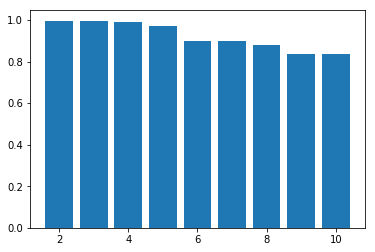

[0.99660254081132671, 0.9933131052804689, 0.99081212179113776, 0.97150624561693222, 0.89841068035492211, 0.89924689392691726, 0.87828269415560734, 0.83540174227650854, 0.83577673982500267]


In [12]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(m)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(m, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
plt.close()

In [18]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(m)
print pd.DataFrame(kmeans.labels_)[0].value_counts()

0    802
7     54
5     12
4      3
6      1
3      1
2      1
1      1
Name: 0, dtype: int64


In [20]:
tmp = pd.DataFrame({'Distribution_Channel':tmp_premium.Distribution_Channel, 'channel_cluster_8':KMeans(n_clusters=8, random_state=0).fit(m).labels_})
policy = pd.merge(policy, tmp, how='left', on='Distribution_Channel')

In [24]:
tmp = policy.groupby('Policy_Number', as_index=False)['channel_cluster_8'].first()
tr = pd.merge(tr, tmp , on = 'Policy_Number', how = 'left')
te = pd.merge(te, tmp , on = 'Policy_Number', how = 'left')

In [15]:
tmp_count = policy.groupby(['iply_area'],as_index=False)["Insured's_ID"].count()
tmp_count.columns = ['iply_area','zip_count']

tmp_premium = policy.groupby(['iply_area'],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['iply_area','mean_Premium_zip', 'std_Premium_zip', 
               'median_Premium_zip', 'sum_Premium_zip', 'min_Premium_zip', 'max_Premium_zip']

tmp_policy = policy.groupby(['iply_area'],as_index=False).agg({'Policy_Number':'nunique'})
tmp_policy.columns = ['iply_area','Policy_Number_distinct_count']

tmp_insuredID = policy.groupby(['iply_area'],as_index=False).agg({"Insured's_ID":'nunique'})
tmp_insuredID.columns = ['iply_area','insuredID_distinct_count']

tmp_repl = policy.groupby(['iply_area'],as_index=False).agg({'Replacement_cost_of_insured_vehicle':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['iply_area','mean_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'std_Replacement_cost_of_insured_vehicle_Distribution_Channel', 
               'median_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'sum_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'min_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'max_Replacement_cost_of_insured_vehicle_Distribution_Channel']

tmp_eng = policy.groupby(['iply_area'],as_index=False).agg({'Engine_Displacement_(Cubic_Centimeter)':['mean','std','median','sum','min','max']})
tmp_eng.columns = ['iply_area','mean_eng_Distribution_Channel', 'std_eng_Distribution_Channel', 
               'median_eng_Distribution_Channel', 'sum_eng_Distribution_Channel', 'min_eng_Distribution_Channel', 'max_eng_Distribution_Channel']

tmp_amt1 = policy.groupby(['iply_area'],as_index=False).agg({'Insured_Amount1':['mean','std','median','sum','min','max']})
tmp_amt1.columns = ['iply_area','mean_amt1_Distribution_Channel', 'std_amt1_Distribution_Channel', 
               'median_amt1_Distribution_Channel', 'sum_amt1_Distribution_Channel', 'min_amt1_Distribution_Channel', 'max_amt1_Distribution_Channel']

tmp_amt2 = policy.groupby(['iply_area'],as_index=False).agg({'Insured_Amount2':['mean','std','median','sum','min','max']})
tmp_amt2.columns = ['iply_area','mean_amt2_Distribution_Channel', 'std_amt2_Distribution_Channel', 
               'median_amt2_Distribution_Channel', 'sum_amt2_Distribution_Channel', 'min_amt2_Distribution_Channel', 'max_amt2_Distribution_Channel']

tmp_amt3 = policy.groupby(['iply_area'],as_index=False).agg({'Insured_Amount3':['mean','std','median','sum','min','max']})
tmp_amt3.columns = ['iply_area','mean_amt3_Distribution_Channel', 'std_amt3_Distribution_Channel', 
               'medianamt3_Distribution_Channel', 'sum_amt3_Distribution_Channel', 'min_amt3_Distribution_Channel', 'max_amt3_Distribution_Channel']


In [16]:
m = pd.concat([tmp_count.iloc[:,1:], 
               tmp_premium.iloc[:,1:],
               tmp_policy.iloc[:,1:],
               tmp_insuredID.iloc[:,1:],
               tmp_repl.iloc[:,1:],
               tmp_eng.iloc[:,1:],
               tmp_amt1.iloc[:,1:],
               tmp_amt2.iloc[:,1:],
               tmp_amt3.iloc[:,1:]
              ],axis=1)
m = m.fillna(0)

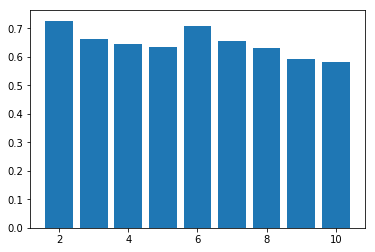

[0.72614028875012226, 0.66351182276296161, 0.64344991496224135, 0.63535549053504747, 0.70587129537517024, 0.65551485507857687, 0.62929154029109047, 0.59014449181607631, 0.58293044211767187]


In [17]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(m)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(m, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
plt.close()

In [18]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(m)
print pd.DataFrame(kmeans.labels_)[0].value_counts()

1    6
5    5
4    3
3    3
2    3
0    2
Name: 0, dtype: int64


In [21]:
tmp = pd.DataFrame({'iply_area':tmp_premium.iply_area, 'iply_cluster_6':KMeans(n_clusters=6, random_state=0).fit(m).labels_})
policy = pd.merge(policy, tmp, how='left', on='iply_area')

In [22]:
tmp = policy.groupby('Policy_Number', as_index=False)['iply_cluster_6'].first()
tr = pd.merge(tr, tmp , on = 'Policy_Number', how = 'left')
te = pd.merge(te, tmp , on = 'Policy_Number', how = 'left')

In [4]:
tmp_count = policy.groupby(['aassured_zip'],as_index=False)["Insured's_ID"].count()
tmp_count.columns = ['aassured_zip','zip_count']

tmp_premium = policy.groupby(['aassured_zip'],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['aassured_zip','mean_Premium_zip', 'std_Premium_zip', 
               'median_Premium_zip', 'sum_Premium_zip', 'min_Premium_zip', 'max_Premium_zip']

tmp_policy = policy.groupby(['aassured_zip'],as_index=False).agg({'Policy_Number':'nunique'})
tmp_policy.columns = ['aassured_zip','Policy_Number_distinct_count']

tmp_insuredID = policy.groupby(['aassured_zip'],as_index=False).agg({"Insured's_ID":'nunique'})
tmp_insuredID.columns = ['aassured_zip','insuredID_distinct_count']

tmp_repl = policy.groupby(['aassured_zip'],as_index=False).agg({'Replacement_cost_of_insured_vehicle':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['aassured_zip','mean_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'std_Replacement_cost_of_insured_vehicle_Distribution_Channel', 
               'median_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'sum_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'min_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'max_Replacement_cost_of_insured_vehicle_Distribution_Channel']

tmp_eng = policy.groupby(['aassured_zip'],as_index=False).agg({'Engine_Displacement_(Cubic_Centimeter)':['mean','std','median','sum','min','max']})
tmp_eng.columns = ['aassured_zip','mean_eng_Distribution_Channel', 'std_eng_Distribution_Channel', 
               'median_eng_Distribution_Channel', 'sum_eng_Distribution_Channel', 'min_eng_Distribution_Channel', 'max_eng_Distribution_Channel']

tmp_amt1 = policy.groupby(['aassured_zip'],as_index=False).agg({'Insured_Amount1':['mean','std','median','sum','min','max']})
tmp_amt1.columns = ['aassured_zip','mean_amt1_Distribution_Channel', 'std_amt1_Distribution_Channel', 
               'median_amt1_Distribution_Channel', 'sum_amt1_Distribution_Channel', 'min_amt1_Distribution_Channel', 'max_amt1_Distribution_Channel']

tmp_amt2 = policy.groupby(['aassured_zip'],as_index=False).agg({'Insured_Amount2':['mean','std','median','sum','min','max']})
tmp_amt2.columns = ['aassured_zip','mean_amt2_Distribution_Channel', 'std_amt2_Distribution_Channel', 
               'median_amt2_Distribution_Channel', 'sum_amt2_Distribution_Channel', 'min_amt2_Distribution_Channel', 'max_amt2_Distribution_Channel']

tmp_amt3 = policy.groupby(['aassured_zip'],as_index=False).agg({'Insured_Amount3':['mean','std','median','sum','min','max']})
tmp_amt3.columns = ['aassured_zip','mean_amt3_Distribution_Channel', 'std_amt3_Distribution_Channel', 
               'medianamt3_Distribution_Channel', 'sum_amt3_Distribution_Channel', 'min_amt3_Distribution_Channel', 'max_amt3_Distribution_Channel']


In [5]:
m = pd.concat([tmp_count.iloc[:,1:], 
               tmp_premium.iloc[:,1:],
               tmp_policy.iloc[:,1:],
               tmp_insuredID.iloc[:,1:],
               tmp_repl.iloc[:,1:],
               tmp_eng.iloc[:,1:],
               tmp_amt1.iloc[:,1:],
               tmp_amt2.iloc[:,1:],
               tmp_amt3.iloc[:,1:]
              ],axis=1)
m = m.fillna(0)

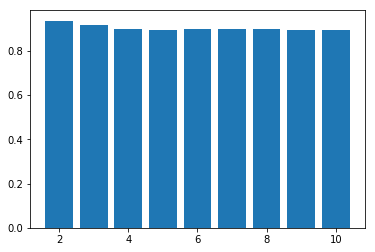

[0.93660131508631905, 0.91897329420813378, 0.90061510511940635, 0.89617319683518337, 0.89850552773592496, 0.89770413881855593, 0.89889135796970443, 0.89355828246732771, 0.89274910066369662]


In [6]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(m)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(m, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
plt.close()

In [11]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(m)
print pd.DataFrame(kmeans.labels_)[0].value_counts()

2    1524
0     111
3      44
1      24
5      17
4       2
Name: 0, dtype: int64


In [12]:
tmp = pd.DataFrame({'aassured_zip':tmp_premium.aassured_zip, 'zip_cluster_6':KMeans(n_clusters=6, random_state=0).fit(m).labels_})
policy = pd.merge(policy, tmp, how='left', on='aassured_zip')

In [13]:
tmp = policy.groupby('Policy_Number', as_index=False)['zip_cluster_6'].first()
tr = pd.merge(tr, tmp , on = 'Policy_Number', how = 'left')
te = pd.merge(te, tmp , on = 'Policy_Number', how = 'left')

In [21]:
tmp_count = policy.groupby(['aassured_zip'],as_index=False)["Insured's_ID"].count()
tmp_count.columns = ['aassured_zip','zip_count']

tmp_premium = policy.groupby(['aassured_zip'],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['aassured_zip','mean_Premium_zip', 'std_Premium_zip', 
               'median_Premium_zip', 'sum_Premium_zip', 'min_Premium_zip', 'max_Premium_zip']

tmp_policy = policy.groupby(['aassured_zip'],as_index=False).agg({'Policy_Number':'nunique'})
tmp_policy.columns = ['aassured_zip','Policy_Number_distinct_count']

tmp_insuredID = policy.groupby(['aassured_zip'],as_index=False).agg({"Insured's_ID":'nunique'})
tmp_insuredID.columns = ['aassured_zip','insuredID_distinct_count']

In [ ]:
m = pd.concat([tmp_count.zip_count, tmp_premium.sum_Premium_zip,
               tmp_premium.mean_Premium_zip,
               tmp_premium.std_Premium_zip,
               tmp_premium.median_Premium_zip,
               tmp_premium.min_Premium_zip,
               tmp_premium.max_Premium_zip,
               tmp_policy.Policy_Number_distinct_count, 
         tmp_insuredID.insuredID_distinct_count],axis=1)
m = m.fillna(0)

In [ ]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(m)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(m, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
plt.close()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(m)
print pd.DataFrame(kmeans.labels_)[0].value_counts()

In [ ]:
tmp = pd.DataFrame({'aassured_zip':tmp_premium.aassured_zip, 'zip_cluster_2':KMeans(n_clusters=2, random_state=0).fit(m).labels_})
policy = pd.merge(policy, tmp, how='left', on='aassured_zip')

In [ ]:
print len(tr)
print len(te)

In [34]:
tmp_count = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False)["Insured's_ID"].count()
tmp_count.columns = ['Vehicle_Make_and_Model1','zip_count']

tmp_premium = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['Vehicle_Make_and_Model1','mean_Premium_zip', 'std_Premium_zip', 
               'median_Premium_zip', 'sum_Premium_zip', 'min_Premium_zip', 'max_Premium_zip']

tmp_policy = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Policy_Number':'nunique'})
tmp_policy.columns = ['Vehicle_Make_and_Model1','Policy_Number_distinct_count']

tmp_insuredID = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({"Insured's_ID":'nunique'})
tmp_insuredID.columns = ['Vehicle_Make_and_Model1','insuredID_distinct_count']
##
tmp_repl = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Replacement_cost_of_insured_vehicle':['mean','std','median','sum','min','max']})
tmp_premium.columns = ['Vehicle_Make_and_Model1','mean_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'std_Replacement_cost_of_insured_vehicle_Distribution_Channel', 
               'median_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'sum_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'min_Replacement_cost_of_insured_vehicle_Distribution_Channel', 'max_Replacement_cost_of_insured_vehicle_Distribution_Channel']

tmp_eng = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Engine_Displacement_(Cubic_Centimeter)':['mean','std','median','sum','min','max']})
tmp_eng.columns = ['Vehicle_Make_and_Model1','mean_eng_Distribution_Channel', 'std_eng_Distribution_Channel', 
               'median_eng_Distribution_Channel', 'sum_eng_Distribution_Channel', 'min_eng_Distribution_Channel', 'max_eng_Distribution_Channel']

tmp_amt1 = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Insured_Amount1':['mean','std','median','sum','min','max']})
tmp_amt1.columns = ['Vehicle_Make_and_Model1','mean_amt1_Distribution_Channel', 'std_amt1_Distribution_Channel', 
               'median_amt1_Distribution_Channel', 'sum_amt1_Distribution_Channel', 'min_amt1_Distribution_Channel', 'max_amt1_Distribution_Channel']

tmp_amt2 = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Insured_Amount2':['mean','std','median','sum','min','max']})
tmp_amt2.columns = ['Vehicle_Make_and_Model1','mean_amt2_Distribution_Channel', 'std_amt2_Distribution_Channel', 
               'median_amt2_Distribution_Channel', 'sum_amt2_Distribution_Channel', 'min_amt2_Distribution_Channel', 'max_amt2_Distribution_Channel']

tmp_amt3 = policy.groupby(['Vehicle_Make_and_Model1'],as_index=False).agg({'Insured_Amount3':['mean','std','median','sum','min','max']})
tmp_amt3.columns = ['Vehicle_Make_and_Model1','mean_amt3_Distribution_Channel', 'std_amt3_Distribution_Channel', 
               'medianamt3_Distribution_Channel', 'sum_amt3_Distribution_Channel', 'min_amt3_Distribution_Channel', 'max_amt3_Distribution_Channel']



In [35]:
m = pd.concat([tmp_count.iloc[:,1:], 
               tmp_premium.iloc[:,1:],
               tmp_policy.iloc[:,1:],
               tmp_insuredID.iloc[:,1:],
               tmp_repl.iloc[:,1:],
               tmp_eng.iloc[:,1:],
               tmp_amt1.iloc[:,1:],
               tmp_amt2.iloc[:,1:],
               tmp_amt3.iloc[:,1:]],axis=1)
m = m.fillna(0)

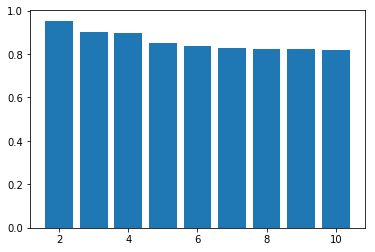

[0.95356417205196209, 0.89992540508520469, 0.89840281671462652, 0.8531950226511239, 0.83801630793524684, 0.8282670101165639, 0.82261393406388572, 0.8211312872739065, 0.81829590920826001]


In [36]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(m)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(m, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
plt.close()

In [42]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(m)
print pd.DataFrame(kmeans.labels_)[0].value_counts()

0    114
5     11
4      6
2      2
1      2
3      1
Name: 0, dtype: int64


In [43]:
tmp = pd.DataFrame({'Vehicle_Make_and_Model1':tmp_premium.Vehicle_Make_and_Model1, 'model1_cluster_6':KMeans(n_clusters=6, random_state=0).fit(m).labels_})
policy = pd.merge(policy, tmp, how='left', on='Vehicle_Make_and_Model1')

In [44]:
tmp = policy.groupby('Policy_Number', as_index=False)['model1_cluster_6'].first()
tr = pd.merge(tr, tmp , on = 'Policy_Number', how = 'left')
te = pd.merge(te, tmp , on = 'Policy_Number', how = 'left')

In [45]:
print len(tr)
print len(te)

210763
140510


In [11]:
policy['dbirth_year'] = policy.dbirth.str.split('/').str[1].fillna(0).astype('int')
policy.loc[(policy.dbirth_year ==0)|(policy.dbirth_year > 2016),'dbirth_year'] = float('nan')
policy['d_age'] = 2016 - policy.dbirth_year

In [ ]:
tmp = pd.get_dummies(claim["Driver's_Relationship_with_Insured"])
tmp.columns = ['relationship1','relationship2','relationship3','relationship4','relationship5','relationship6',
              'relationship7']
claim = pd.concat([claim, tmp], axis=1)

In [ ]:
print claim.Accident_Date.head()
print claim.Accident_Time.head()

In [ ]:
tmp = pd.get_dummies(policy.Imported_or_Domestic_Car)
tmp.columns = ['car_10','car_20','car_21','car_22','car_23','car_24','car_30','car_40','car_50','car_90']
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 136
fh = FeatureHasher(n_features=5, input_type='string')
tmp = fh.transform(policy.Vehicle_Make_and_Model1)
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["model1_haser1","model1_haser2","model1_haser3","model1_haser4","model1_haser5"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 8112
fh = FeatureHasher(n_features=10, input_type='string')
tmp = fh.transform(policy.Vehicle_Make_and_Model2)
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["model2_haser1","model2_haser2","model2_haser3","model2_haser4","model2_haser5",
              "model2_haser6","model2_haser7","model2_haser8","model2_haser9","model2_haser10"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 7405
fh = FeatureHasher(n_features=10, input_type='string')
tmp = fh.transform(policy["Coding_of_Vehicle_Branding_&_Type"])
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["Branding_haser1","Branding_haser2","Branding_haser3","Branding_haser4","Branding_haser5",
              "Branding_haser6","Branding_haser7","Branding_haser8","Branding_haser9","Branding_haser10"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 22
fh = FeatureHasher(n_features=5, input_type='string')
tmp = fh.transform(policy.iply_area)
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["iply_haser1","iply_haser2","iply_haser3","iply_haser4","iply_haser5"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 1722
fh = FeatureHasher(n_features=10, input_type='string')
tmp = fh.transform(policy.aassured_zip)
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["zip_haser1","zip_haser2","zip_haser3","zip_haser4","zip_haser5",
              "zip_haser6","zip_haser7","zip_haser8","zip_haser9","zip_haser10"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 875
fh = FeatureHasher(n_features=10, input_type='string')
tmp = fh.transform(policy.Distribution_Channel)
tmp = pd.DataFrame(tmp.toarray())
tmp.columns = ["zip_haser1","zip_haser2","zip_haser3","zip_haser4","zip_haser5",
              "zip_haser6","zip_haser7","zip_haser8","zip_haser9","zip_haser10"]
policy = pd.concat([policy, tmp], axis=1)

In [ ]:
# 賠案性質
tmp = pd.get_dummies(claim.Nature_of_the_claim)
tmp.columns = ['Nature_1','Nature_2']
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
# 駕駛人性別
tmp = pd.get_dummies(claim["Driver's_Gender"])
tmp.columns = ['driver_gender_1','driver_gender_2']
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
# 肇事駕駛婚姻
tmp = pd.get_dummies(claim["Marital_Status_of_Driver"])
tmp.columns = ['driver_marriage_1','driver_marriage_2']
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
print len(np.unique(claim["Cause_of_Loss"]))

In [ ]:
# 肇事原因
tmp = pd.get_dummies(claim["Cause_of_Loss"])
tmp.columns = ['name_{}'.format(i) for i in range(len(np.unique(claim["Cause_of_Loss"])))]
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
# 險種代號
tmp = pd.get_dummies(claim["Coverage"])
tmp.columns = ['claim_'+ tmp.columns[i] for i in range(len(np.unique(claim["Coverage"])))]
claim = pd.concat([claim,tmp], axis=1)

In [12]:
# 肇事駕駛年齡
claim["DOB_of_Driver"] = pd.to_datetime(claim.DOB_of_Driver)
claim["claim_driver_year"] = claim.DOB_of_Driver.dt.year
claim["claim_driver_age"] = 2016 - claim.claim_driver_year

In [71]:
# 單一險種close
tmp = pd.get_dummies(claim["Claim_Status_(close,_open,_reopen_etc)"])
tmp.columns = ['n_not_close','n_close']
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
print len(np.unique(claim["Accident_area"]))

In [ ]:
tmp = pd.get_dummies(claim["Accident_area"])
claim = pd.concat([claim,tmp], axis=1)

In [ ]:
policy.Main_Insurance_Coverage_Group.value_counts() / len(policy)

In [ ]:
print len(tr)
print len(te)

# Feature Engineering 

In [ ]:
# 保單金額
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Premium':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Premium', 'std_Premium', 
               'median_Premium', 'sum_Premium', 'min_Premium', 'max_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 保額一二三
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Insured_Amount':['mean','sum']})
tmp.columns = ['Policy_Number','mean_Insured_Amount', 'sum_Insured_Amount']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 保額1
#policy[['Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3']]
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Insured_Amount1':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Insured_Amount1', 'std_Insured_Amount1', 
               'median_Insured_Amount1', 'sum_Insured_Amount1', 'min_Insured_Amount1', 'max_Insured_Amount1']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 保額2
#policy[['Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3']]
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Insured_Amount2':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Insured_Amount2', 'std_Insured_Amount2', 
               'median_Insured_Amount2', 'sum_Insured_Amount2', 'min_Insured_Amount2', 'max_Insured_Amount2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 保額3
#policy[['Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3']]
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Insured_Amount3':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Insured_Amount3', 'std_Insured_Amount3', 
               'median_Insured_Amount3', 'sum_Insured_Amount3', 'min_Insured_Amount3', 'max_Insured_Amount3']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# Imported car
tmp = policy.groupby('Policy_Number', as_index=0)['Imported_or_Domestic_Car'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 乘載數量
tmp = policy.groupby(["Policy_Number"],as_index=False).qpt.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 重置成本
tmp = policy.groupby(["Policy_Number"],as_index=False)["Replacement_cost_of_insured_vehicle"].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 排氣量
tmp = policy.groupby(["Policy_Number"],as_index=False)["Engine_Displacement_(Cubic_Centimeter)"].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 被保人年齡
tmp = policy.groupby(["Policy_Number"],as_index=False)['age'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
print len(tr)
print len(te)

In [ ]:
# 要保人年齡
#tmp = policy.groupby(["Policy_Number"],as_index=False)['d_age'].first()
#tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
#te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 前一年度非車險
tmp = policy.groupby(["Policy_Number"],as_index=False)['Multiple_Products_with_TmNewa_(Yes_or_No?)'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
##policy[policy.Policy_Number == '000061141b237e8619efedcd6939fddeff05b9a5']['Coverage_Deductible_if_applied']
##policy.groupby('Policy_Number', as_index=0).agg({'Coverage_Deductible_if_applied':'std'})

In [ ]:
# 車責、車體係數
tmp = policy.groupby(["Policy_Number"],as_index=False)['lia_class','plia_acc', 'pdmg_acc'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 自負額
tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Coverage_Deductible_if_applied':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Deductible', 'std_Deductible', 
               'median_Deductible', 'sum_Deductible', 'min_Deductible', 'max_Deductible']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
##policy[['Policy_Number','Coverage_Group0','Coverage_Group1','Coverage_Group2']]

In [ ]:
# 各險種次數
tmp = policy.groupby('Policy_Number',as_index=False)[['Coverage_Group0','Coverage_Group1','Coverage_Group2']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 是否有各險種
tr.loc[tr.Coverage_Group0 > 0 ,'Coverage_Group0_YN'] = 1
tr.loc[tr.Coverage_Group1 > 0 ,'Coverage_Group1_YN'] = 1
tr.loc[tr.Coverage_Group2 > 0 ,'Coverage_Group2_YN'] = 1
te.loc[te.Coverage_Group0 > 0 ,'Coverage_Group0_YN'] = 1
te.loc[te.Coverage_Group1 > 0 ,'Coverage_Group1_YN'] = 1
te.loc[te.Coverage_Group2 > 0 ,'Coverage_Group2_YN'] = 1

tr.loc[tr.Coverage_Group0 == 0 ,'Coverage_Group0_YN'] = 0
tr.loc[tr.Coverage_Group1 == 0 ,'Coverage_Group1_YN'] = 0
tr.loc[tr.Coverage_Group2 == 0 ,'Coverage_Group2_YN'] = 0
te.loc[te.Coverage_Group0 == 0 ,'Coverage_Group0_YN'] = 0
te.loc[te.Coverage_Group1 == 0 ,'Coverage_Group1_YN'] = 0
te.loc[te.Coverage_Group2 == 0 ,'Coverage_Group2_YN'] = 0

In [ ]:
# 與被保險人關係
tmp = claim.groupby('Policy_Number',as_index=False)[['relationship1','relationship2','relationship3','relationship4','relationship5','relationship6',
              'relationship7']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.relationship1 > 0 ,'relationship1_YN'] = 1
tr.loc[tr.relationship2 > 0 ,'relationship2_YN'] = 1
tr.loc[tr.relationship3 > 0 ,'relationship3_YN'] = 1
tr.loc[tr.relationship4 > 0 ,'relationship4_YN'] = 1
tr.loc[tr.relationship5 > 0 ,'relationship5_YN'] = 1
tr.loc[tr.relationship6 > 0 ,'relationship6_YN'] = 1
tr.loc[tr.relationship7 > 0 ,'relationship7_YN'] = 1
te.loc[te.relationship1 > 0 ,'relationship1_YN'] = 1
te.loc[te.relationship2 > 0 ,'relationship2_YN'] = 1
te.loc[te.relationship3 > 0 ,'relationship3_YN'] = 1
te.loc[te.relationship4 > 0 ,'relationship4_YN'] = 1
te.loc[te.relationship5 > 0 ,'relationship5_YN'] = 1
te.loc[te.relationship6 > 0 ,'relationship6_YN'] = 1
te.loc[te.relationship7 > 0 ,'relationship7_YN'] = 1

tr.loc[tr.relationship1 == 0 ,'relationship1_YN'] = 0
tr.loc[tr.relationship2 == 0 ,'relationship2_YN'] = 0
tr.loc[tr.relationship3 == 0 ,'relationship3_YN'] = 0
tr.loc[tr.relationship4 == 0 ,'relationship4_YN'] = 0
tr.loc[tr.relationship5 == 0 ,'relationship5_YN'] = 0
tr.loc[tr.relationship6 == 0 ,'relationship6_YN'] = 0
tr.loc[tr.relationship7 == 0 ,'relationship7_YN'] = 0
te.loc[te.relationship1 == 0 ,'relationship1_YN'] = 0
te.loc[te.relationship2 == 0 ,'relationship2_YN'] = 0
te.loc[te.relationship3 == 0 ,'relationship3_YN'] = 0
te.loc[te.relationship4 == 0 ,'relationship4_YN'] = 0
te.loc[te.relationship5 == 0 ,'relationship5_YN'] = 0
te.loc[te.relationship6 == 0 ,'relationship6_YN'] = 0
te.loc[te.relationship7 == 0 ,'relationship7_YN'] = 0

In [ ]:
# 賠案性質
tmp = claim.groupby('Policy_Number',as_index=False)[['Nature_1','Nature_2']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.Nature_1 > 0 ,'Nature_1_YN'] = 1
tr.loc[tr.Nature_2 > 0 ,'Nature_2_YN'] = 1

te.loc[te.Nature_1 > 0 ,'Nature_1_YN'] = 1
te.loc[te.Nature_2 > 0 ,'Nature_2_YN'] = 1


tr.loc[tr.Nature_1 == 0 ,'Nature_1_YN'] = 0
tr.loc[tr.Nature_2 == 0 ,'Nature_2_YN'] = 0

te.loc[te.Nature_1 == 0 ,'Nature_1_YN'] = 0
te.loc[te.Nature_2 == 0 ,'Nature_2_YN'] = 0


In [ ]:
# 駕駛人性別
['driver_gender_1','driver_gender_2']

tmp = claim.groupby('Policy_Number',as_index=False)[['driver_gender_1','driver_gender_2']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.driver_gender_1 > 0 ,'driver_gender_1_YN'] = 1
tr.loc[tr.driver_gender_2 > 0 ,'driver_gender_2_YN'] = 1

te.loc[te.driver_gender_1 > 0 ,'driver_gender_1_YN'] = 1
te.loc[te.driver_gender_2 > 0 ,'driver_gender_2_YN'] = 1


tr.loc[tr.driver_gender_1 == 0 ,'driver_gender_1_YN'] = 0
tr.loc[tr.driver_gender_2 == 0 ,'driver_gender_2_YN'] = 0

te.loc[te.driver_gender_1 == 0 ,'driver_gender_1_YN'] = 0
te.loc[te.driver_gender_2 == 0 ,'driver_gender_2_YN'] = 0

In [ ]:
# 肇事駕駛婚姻
['driver_marriage_1','driver_marriage_2']

tmp = claim.groupby('Policy_Number',as_index=False)[['driver_marriage_1','driver_marriage_2']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.driver_marriage_1 > 0 ,'driver_marriage_1_YN'] = 1
tr.loc[tr.driver_marriage_2 > 0 ,'driver_marriage_2_YN'] = 1

te.loc[te.driver_marriage_1 > 0 ,'driver_marriage_1_YN'] = 1
te.loc[te.driver_marriage_2 > 0 ,'driver_marriage_2_YN'] = 1


tr.loc[tr.driver_marriage_1 == 0 ,'driver_marriage_1_YN'] = 0
tr.loc[tr.driver_marriage_2 == 0 ,'driver_marriage_2_YN'] = 0

te.loc[te.driver_marriage_1 == 0 ,'driver_marriage_1_YN'] = 0
te.loc[te.driver_marriage_2 == 0 ,'driver_marriage_2_YN'] = 0

In [ ]:
# 肇事原因
tmp = pd.get_dummies(claim["Cause_of_Loss"])
tmp = claim.groupby('Policy_Number',as_index=False)[['name_{}'.format(i) for i in range(len(np.unique(claim["Cause_of_Loss"])))]].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# claim 險種代號
tmp = pd.get_dummies(claim["Coverage"])
tmp = claim.groupby('Policy_Number',as_index=False)[['claim_'+ tmp.columns[i] for i in range(len(np.unique(claim["Coverage"])))]].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# claim 險種代號的
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Premium')
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 是否遇到追償
#claim.loc[claim["Salvage_or_Subrogation?"] > 0 ,'SoS_or_not'] = 1
tmp = claim.groupby('Policy_Number', as_index = 0)["SoS_or_not"].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 被保險人性質
tmp = policy.groupby(["Policy_Number"],as_index=False)[['fassured1','fassured2','fassured3','fassured6']].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 婚姻
tmp = policy.groupby(["Policy_Number"],as_index=False)[['fmarriage0','fmarriage1','fmarriage2']].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 性別
tmp = policy.groupby(["Policy_Number"],as_index=False)[['fsex0','fsex1','fsex2']].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 製造年齡
tmp = policy.groupby(["Policy_Number"],as_index=False)['Manafactured_Year_and_Month'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# Cancellation
tmp = policy.groupby(["Policy_Number"],as_index=False)['Cancellation'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 車責
tmp = policy.groupby(["Policy_Number"],as_index=False).lia.first()
tmp.columns = ['Policy_Number','lia']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 車責
tmp = policy.groupby(["Policy_Number"],as_index=False).acc.first()
tmp.columns = ['Policy_Number','acc']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
 # 保單被購買次數 = 保單被購買的險種種數，一張保單對應到一個被保險人，但一個人可以買很多保單(不同保單或同一保單不同險種)
tmp = policy.groupby(["Policy_Number"],as_index=False)["Insured's_ID"].count()
#tmp = policy.groupby(["Policy_Number"],as_index=False).agg({'Insurance_Coverage':'nunique'})
tmp = tmp.rename(columns={"Insured's_ID":'Policy_showup_Numbers'})
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# zip cluster
#tmp = policy.groupby(["Policy_Number"],as_index=False)["zip_cluster"].first()
#tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
#te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

# zip cluster 2
tmp = policy.groupby(["Policy_Number"],as_index=False)["zip_cluster_2"].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# model1 cluster
tmp = policy.groupby(["Policy_Number"],as_index=False)["model1_cluster_6"].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 保單理賠幾次
tmp = claim.groupby(['Policy_Number'], as_index=False)['Claim_Number'].count()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')
tr.Claim_Number = tr.Claim_Number.fillna(0)
te.Claim_Number = te.Claim_Number.fillna(0)

In [ ]:
# 已決賠款
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'Paid_Loss_Amount':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Loss', 'std_Loss', 
               'median_Loss', 'sum_Loss', 'min_Loss', 'max_Loss']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 已決費用
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'paid_Expenses_Amount':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_Expenses', 'std_Expenses', 
               'median_Expenses', 'sum_Expenses', 'min_Expenses', 'max_Expenses']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 已決金額
claim['total_paid'] = claim.paid_Expenses_Amount + claim.Paid_Loss_Amount
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'total_paid':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_total_paid', 'std_total_paid', 
               'median_total_paid', 'sum_total_paid', 'min_total_paid', 'max_total_paid']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 事故關係人數
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'number_of_claimants':['mean','std','median','sum','min','max']})
tmp.columns = ['Policy_Number','mean_claimants', 'std_claimants', 
               'median_claimants', 'sum_claimants', 'min_claimants', 'max_claimants']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [ ]:
# 追償金額
tmp = claim.groupby(["Policy_Number"],as_index=False)["Salvage_or_Subrogation?"].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tmp = claim.groupby(["Policy_Number"],as_index=False)["Salvage_or_Subrogation?"].mean()
tmp.columns = ["Policy_Number", "mean_Salvage_or_Subrogation"]
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 自負額
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'Deductible':['mean','sum']})
tmp.columns = ['Policy_Number','mean_claim_Deductible','sum_claim_Deductible']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 自負額
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'At_Fault?':['mean','sum']})
tmp.columns = ['Policy_Number','mean_Fault','sum_Fault']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 肇事駕駛年齡
tmp = claim.groupby(["Policy_Number"],as_index=False).agg({'claim_driver_age':['mean','min','max']})
tmp.columns = ['Policy_Number','mean_driver_age','min_driver_age', 'max_driver_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 出險地區
tmp = claim.groupby('Policy_Number',as_index=False)[[u'0286dd552c9bea9a69ecb3759e7b94777635514b',
       u'17ba0791499db908433b80f37c5fbc89b870084b',
       u'1d513c0bcbe33b2e7440e5e14d0b22ef95c9d673',
       u'2a459380709e2fe4ac2dae5733c73225ff6cfee1',
       u'2d0c8af807ef45ac17cafb2973d866ba8f38caa9',
       u'356a192b7913b04c54574d18c28d46e6395428ab',
       u'4d89d294cd4ca9f2ca57dc24a53ffb3ef5303122',
       u'511a418e72591eb7e33f703f04c3fa16df6c90bd',
       u'59129aacfb6cebbe2c52f30ef3424209f7252e82',
       u'6c1e671f9af5b46d9c1a52067bdf0e53685674f7',
       u'761f22b2c1593d0bb87e0b606f990ba4974706de',
       u'76546f9a641ede2beab506b96df1688d889e629a',
       u'7b52009b64fd0a2a49e6d8a939753077792b0554',
       u'92cfceb39d57d914ed8b14d0e37643de0797ae56',
       u'98fbc42faedc02492397cb5962ea3a3ffc0a9243',
       u'a17554a0d2b15a664c0e73900184544f19e70227',
       u'bd307a3ec329e10a2cff8fb87480823da114f8f4',
       u'c1dfd96eea8cc2b62785275bca38ac261256e278',
       u'c66c65175fecc3103b3b587be9b5b230889c8628',
       u'f1abd670358e036c31296e66b3b66c382ac00812',
       u'fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b',
       u'fb644351560d8296fe6da332236b1f8d61b2828a']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [72]:
# 單一險種close
['n_not_close','n_close']
tmp = claim.groupby('Policy_Number',as_index=False)[['n_not_close','n_close']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.n_not_close > 0 ,'n_not_close_YN'] = 1
tr.loc[tr.n_close > 0 ,'n_close_YN'] = 1

te.loc[te.n_not_close > 0 ,'n_not_close_YN'] = 1
te.loc[te.n_close > 0 ,'n_close_YN'] = 1


tr.loc[tr.n_not_close == 0 ,'n_not_close_YN'] = 0
tr.loc[tr.n_close == 0 ,'n_close_YN'] = 0

te.loc[te.n_not_close == 0 ,'n_not_close_YN'] = 0
te.loc[te.n_close == 0 ,'n_close_YN'] = 0

In [ ]:
#import car
['car_10','car_20','car_21','car_22','car_23','car_24','car_30','car_40','car_50','car_90']
tmp = policy.groupby(["Policy_Number"],as_index=False)[['car_10','car_20','car_21','car_22','car_23','car_24','car_30','car_40','car_50','car_90']].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr.loc[tr.car_10 > 0 ,'car_10_YN'] = 1
tr.loc[tr.car_20 > 0 ,'car_20_YN'] = 1
tr.loc[tr.car_21 > 0 ,'car_21_YN'] = 1
tr.loc[tr.car_22 > 0 ,'car_22_YN'] = 1
tr.loc[tr.car_23 > 0 ,'car_23_YN'] = 1
tr.loc[tr.car_24 > 0 ,'car_24_YN'] = 1
tr.loc[tr.car_30 > 0 ,'car_30_YN'] = 1
tr.loc[tr.car_40 > 0 ,'car_40_YN'] = 1
tr.loc[tr.car_50 > 0 ,'car_50_YN'] = 1
tr.loc[tr.car_90 > 0 ,'car_90_YN'] = 1

te.loc[te.car_10 > 0 ,'car_10_YN'] = 1
te.loc[te.car_20 > 0 ,'car_20_YN'] = 1
te.loc[te.car_21 > 0 ,'car_21_YN'] = 1
te.loc[te.car_22 > 0 ,'car_22_YN'] = 1
te.loc[te.car_23 > 0 ,'car_23_YN'] = 1
te.loc[te.car_24 > 0 ,'car_24_YN'] = 1
te.loc[te.car_30 > 0 ,'car_30_YN'] = 1
te.loc[te.car_40 > 0 ,'car_40_YN'] = 1
te.loc[te.car_50 > 0 ,'car_50_YN'] = 1
te.loc[te.car_90 > 0 ,'car_90_YN'] = 1

tr.loc[tr.car_10 == 0 ,'car_10_YN'] = 0
tr.loc[tr.car_20 == 0 ,'car_20_YN'] = 0
tr.loc[tr.car_21 == 0 ,'car_21_YN'] = 0
tr.loc[tr.car_22 == 0 ,'car_22_YN'] = 0
tr.loc[tr.car_23 == 0 ,'car_23_YN'] = 0
tr.loc[tr.car_24 == 0 ,'car_24_YN'] = 0
tr.loc[tr.car_30 == 0 ,'car_30_YN'] = 0
tr.loc[tr.car_40 == 0 ,'car_40_YN'] = 0
tr.loc[tr.car_50 == 0 ,'car_50_YN'] = 0
tr.loc[tr.car_90 == 0 ,'car_90_YN'] = 0

te.loc[te.car_10 == 0 ,'car_10_YN'] = 0
te.loc[te.car_20 == 0 ,'car_20_YN'] = 0
te.loc[te.car_21 == 0 ,'car_21_YN'] = 0
te.loc[te.car_22 == 0 ,'car_22_YN'] = 0
te.loc[te.car_23 == 0 ,'car_23_YN'] = 0
te.loc[te.car_24 == 0 ,'car_24_YN'] = 0
te.loc[te.car_30 == 0 ,'car_30_YN'] = 0
te.loc[te.car_40 == 0 ,'car_40_YN'] = 0
te.loc[te.car_50 == 0 ,'car_50_YN'] = 0
te.loc[te.car_90 == 0 ,'car_90_YN'] = 0

In [ ]:
# channel labelencoder
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.Distribution_Channel)
tmp = pd.DataFrame(tmp)
tmp.columns = ['Channel']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).Channel.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# import car labelencoder
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.Imported_or_Domestic_Car)
tmp = pd.DataFrame(tmp)
tmp.columns = ['Imported_cars']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).Imported_cars.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# Model1
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.Vehicle_Make_and_Model1)
tmp = pd.DataFrame(tmp)
tmp.columns = ['Model1']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).Model1.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# Model2
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.Vehicle_Make_and_Model2)
tmp = pd.DataFrame(tmp)
tmp.columns = ['Model2']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).Model2.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [154]:
# Coding_of_Vehicle_Branding_&_Type
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy["Coding_of_Vehicle_Branding_&_Type"])
tmp = pd.DataFrame(tmp)
tmp.columns = ['Type']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).Type.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [23]:
# iply labelencoder
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.iply_area)
tmp = pd.DataFrame(tmp)
tmp.columns = ['iply']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).iply.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [27]:
# zip labelencoder
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.aassured_zip)
tmp = pd.DataFrame(tmp)
tmp.columns = ['zip']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).zip.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# prior labelencoder
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(policy.aassured_zip)
tmp = pd.DataFrame(tmp)
tmp.columns = ['zip']
policy = pd.concat([policy, pd.DataFrame(tmp)],axis=1)
tmp = policy.groupby('Policy_Number', as_index=False).zip.first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [77]:
# Model1 * Model2
tr["Model"] = tr.Model1 * tr.Model2
te["Model"] = te.Model1 * te.Model2

In [156]:
# Model * Type
tr['model_type'] = tr.Model * tr.Type
te['model_type'] = te.Model * te.Type

In [ ]:
tmp = policy.groupby(["Policy_Number"],as_index=False)[["model1_haser1","model1_haser2","model1_haser3","model1_haser4","model1_haser5"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
tmp = policy.groupby(["Policy_Number"],as_index=False)[["model2_haser1","model2_haser2","model2_haser3","model2_haser4","model2_haser5",
              "model2_haser6","model2_haser7","model2_haser8","model2_haser9","model2_haser10"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
tmp = policy.groupby(["Policy_Number"],as_index=False)[["Branding_haser1","Branding_haser2","Branding_haser3","Branding_haser4","Branding_haser5",
              "Branding_haser6","Branding_haser7","Branding_haser8","Branding_haser9","Branding_haser10"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
tmp = policy.groupby(["Policy_Number"],as_index=False)[["iply_haser1","iply_haser2","iply_haser3","iply_haser4","iply_haser5"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
tmp = policy.groupby(["Policy_Number"],as_index=False)[["zip_haser1","zip_haser2","zip_haser3","zip_haser4","zip_haser5",
              "zip_haser6","zip_haser7","zip_haser8","zip_haser9","zip_haser10"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# 險種代碼 x Premium
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Premium')
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [202]:
# 險種代碼 x Insured_Amount
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Insured_Amount')
tmp.columns = [ 'Insured_Amount_'+ str(i) for i in tmp.columns.values]
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [368]:
# 險種代碼 x Insured_Amount1
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Insured_Amount1')
tmp.columns = [ 'Insured_Amount1_'+ str(i) for i in tmp.columns.values]
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [369]:
# 險種代碼 x Insured_Amount2
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Insured_Amount2')
tmp.columns = [ 'Insured_Amount2_'+ str(i) for i in tmp.columns.values]
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [370]:
# 險種代碼 x Insured_Amount3
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= 'Insured_Amount3')
tmp.columns = [ 'Insured_Amount3_'+ str(i) for i in tmp.columns.values]
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [371]:
# 險種代碼 x Coverage_Deductible_if_applied
tmp = policy.pivot_table(index= 'Policy_Number', columns= 'Insurance_Coverage', values= "Coverage_Deductible_if_applied")
tmp.columns = [ 'IDeductible_'+ str(i) for i in tmp.columns.values]
tmp = tmp.reset_index(drop=False)
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [66]:
len(np.unique(policy["Coding_of_Vehicle_Branding_&_Type"]))

7405

In [68]:
print len(tr)
print len(te)

210763
140510


In [ ]:
_all = pd.DataFrame([])
skf = StratifiedKFold(n_splits=3, random_state=2018)
skf.get_n_splits(tr['Policy_Number'].values, tr['Next_Premium'].values)

In [ ]:
def get_feature_coverage_Next_Premium_ratio(df_by_file):
	##
	df_by_file_Insurance_Coverage = df_by_file[~df_by_file[['Insurance_Coverage']].duplicated()]
	df_by_file_Insurance_Coverage = df_by_file_Insurance_Coverage.dropna(subset=['Next_Premium'])
	Insurance_Coverage_ratio_mean = df_by_file_Insurance_Coverage.Next_Premium.mean()
	Insurance_Coverage_ratio_std = df_by_file_Insurance_Coverage.Next_Premium.std()
	Insurance_Coverage_ratio_0, Insurance_Coverage_ratio_10, Insurance_Coverage_ratio_20, Insurance_Coverage_ratio_30, Insurance_Coverage_ratio_40, Insurance_Coverage_ratio_50, Insurance_Coverage_ratio_60, Insurance_Coverage_ratio_70, Insurance_Coverage_ratio_80, Insurance_Coverage_ratio_90, Insurance_Coverage_ratio_100 =  df_by_file_Insurance_Coverage['Next_Premium'].quantile(0),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.1),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.2), \
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.3),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.4), \
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.5), \
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.6), \
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.8),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.8),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(0.9),\
	    df_by_file_Insurance_Coverage['Next_Premium'].quantile(1)
	Insurance_Coverage_ratio_range = Insurance_Coverage_ratio_100 - Insurance_Coverage_ratio_0
	##

	return pd.Series((
		Insurance_Coverage_ratio_mean, Insurance_Coverage_ratio_std, Insurance_Coverage_ratio_range, 
		Insurance_Coverage_ratio_0, Insurance_Coverage_ratio_10, Insurance_Coverage_ratio_20, Insurance_Coverage_ratio_30, Insurance_Coverage_ratio_40, Insurance_Coverage_ratio_50, Insurance_Coverage_ratio_60, Insurance_Coverage_ratio_70, Insurance_Coverage_ratio_80, Insurance_Coverage_ratio_90, Insurance_Coverage_ratio_100),
		index=[
		'Insurance_Coverage_ratio_mean', 'Insurance_Coverage_ratio_std', 'Insurance_Coverage_ratio_range',
		'Insurance_Coverage_ratio_0', 'Insurance_Coverage_ratio_10', 'Insurance_Coverage_ratio_20', 'Insurance_Coverage_ratio_30', 'Insurance_Coverage_ratio_40', 'Insurance_Coverage_ratio_50', 'Insurance_Coverage_ratio_60', 'Insurance_Coverage_ratio_70', 'Insurance_Coverage_ratio_80', 'Insurance_Coverage_ratio_90', 'Insurance_Coverage_ratio_100'
		])

In [ ]:
for train_index, test_index in skf.split(tr['Policy_Number'].values, tr['Next_Premium'].values):
	print('qq')
	train_tmp = tr.iloc[train_index]
	tmp = pd.merge(train_tmp, policy, on='Policy_Number', how='left')
	tmp_mean = tmp.groupby('Insurance_Coverage')['Next_Premium'].mean()
	tmp_mean = pd.DataFrame(tmp_mean)
	tmp_mean['Insurance_Coverage'] = tmp_mean.index

	test_tmp = tr.iloc[test_index]
	test_tmp = test_tmp.rename(columns={'Next_Premium':'qq'})
	test_tmp_query_log = pd.merge(test_tmp, policy, on='Policy_Number',how='left')
	test_tmp_query_log = pd.merge(test_tmp_query_log, tmp_mean, on='Insurance_Coverage',how='left')
	a = test_tmp_query_log.groupby('Policy_Number').apply(get_feature_coverage_Next_Premium_ratio)
	_all = _all.append(a)

_all.to_csv('cv_Insurance_Coverage_ratio.csv')

In [ ]:
#train_tmp = pd.read_csv('/Users/charlie/Desktop/TrendMicro/training-set.csv', names=['FileID','res'])
#test_tmp = pd.read_csv('/Users/charlie/Desktop/TrendMicro/testing-set.csv', names=['FileID','res'])
tmp = pd.merge(tr, policy, on='Policy_Number', how='left')
tmp_mean = tmp.groupby('Insurance_Coverage')['Next_Premium'].mean()
tmp_mean = pd.DataFrame(tmp_mean)
tmp_mean['Insurance_Coverage'] = tmp_mean.index

test_tmp = te.rename(columns={'Next_Premium':'qq'})
test_tmp_query_log = pd.merge(test_tmp, policy, on='Policy_Number',how='left')
test_tmp_query_log = pd.merge(test_tmp_query_log, tmp_mean, on='Insurance_Coverage',how='left')
a = test_tmp_query_log.groupby('Policy_Number').apply(get_feature_coverage_Next_Premium_ratio)
a.to_csv('cv_Insurance_Coverage_ratio_test.csv')

In [ ]:
cv_Insurance_Coverage_ratio = pd.read_csv('/Users/charlie/cv_Insurance_Coverage_ratio.csv')
cv_Insurance_Coverage_ratio_test = pd.read_csv('/Users/charlie/cv_Insurance_Coverage_ratio_test.csv')
tr = pd.merge(tr, cv_Insurance_Coverage_ratio, how = 'left', on = 'Policy_Number')
te = pd.merge(te, cv_Insurance_Coverage_ratio_test, how = 'left', on = 'Policy_Number') 

In [ ]:
tr = tr.drop('Premium_Vehicle1',1)
te = te.drop('Premium_Vehicle1',1)

In [ ]:
# method revised
_all = pd.DataFrame([])
skf = StratifiedKFold(n_splits=3, random_state=2018)
skf.get_n_splits(tr['Policy_Number'].values, tr['Next_Premium'].values)
for train_index, test_index in skf.split(tr['Policy_Number'].values, tr['Next_Premium'].values):
    print('qq')
    train_tmp = tr[['Policy_Number']].iloc[train_index]
    tmp = pd.merge(train_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1','Premium']], on='Policy_Number', how='left')
    tmp_mean = tmp.groupby('Vehicle_Make_and_Model1')['Premium'].mean()
    tmp_mean = pd.DataFrame(tmp_mean)
    tmp_mean['Vehicle_Make_and_Model1'] = tmp_mean.index

    test_tmp = tr[['Policy_Number']].iloc[test_index]
    test_tmp_query_log = pd.merge(test_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1','Premium']], on='Policy_Number',how='left')
    test_tmp_query_log = test_tmp_query_log.rename(columns={'Premium':'qq'})
    test_tmp_query_log = pd.merge(test_tmp_query_log, tmp_mean, on='Vehicle_Make_and_Model1',how='left')
    test_tmp_query_log = test_tmp_query_log[~test_tmp_query_log.duplicated()]
    test_tmp_query_log = test_tmp_query_log.groupby('Policy_Number', as_index=False).Premium.mean()
    _all = _all.append(test_tmp_query_log)
    
_all.columns = ['Policy_Number','Premium_Vehicle1']

tmp = pd.merge(tr[['Policy_Number']], policy[['Policy_Number','Vehicle_Make_and_Model1','Premium']], on='Policy_Number', how='left')
tmp_mean = tmp.groupby('Vehicle_Make_and_Model1')['Premium'].mean()
tmp_mean = pd.DataFrame(tmp_mean)
tmp_mean['Vehicle_Make_and_Model1'] = tmp_mean.index

test_tmp = te[['Policy_Number']]
test_tmp_query_log = pd.merge(test_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1','Premium']], on='Policy_Number',how='left')
test_tmp_query_log = test_tmp_query_log.rename(columns={'Premium':'qq'})
a1 = pd.merge(test_tmp_query_log, tmp_mean, on='Vehicle_Make_and_Model1',how='left')
a1 = a1[~a1.duplicated()]
a2 = a1.groupby('Policy_Number', as_index=False).Premium.mean()
a2.columns = ['Policy_Number','Premium_Vehicle1']

#tr = pd.merge(tr, _all, how = 'left', on = 'Policy_Number')
#te = pd.merge(te, a2, how = 'left', on = 'Policy_Number') 

In [ ]:
print len(_all)
print len(a2)

In [ ]:
# method revised
_all = pd.DataFrame([])
skf = StratifiedKFold(n_splits=3, random_state=2018)
skf.get_n_splits(tr['Policy_Number'].values, tr['Next_Premium'].values)
for train_index, test_index in skf.split(tr['Policy_Number'].values, tr['Next_Premium'].values):
    print('qq')
    train_tmp = tr[['Policy_Number','Next_Premium']].iloc[train_index]
    tmp = pd.merge(train_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1']], on='Policy_Number', how='left')
    tmp_mean = tmp.groupby('Vehicle_Make_and_Model1')['Next_Premium'].mean()
    tmp_mean = pd.DataFrame(tmp_mean)
    tmp_mean['Vehicle_Make_and_Model1'] = tmp_mean.index

    test_tmp = tr[['Policy_Number','Next_Premium']].iloc[test_index]
    test_tmp_query_log = pd.merge(test_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1']], on='Policy_Number',how='left')
    test_tmp_query_log = test_tmp_query_log.rename(columns={'Next_Premium':'qq'})
    test_tmp_query_log = pd.merge(test_tmp_query_log, tmp_mean, on='Vehicle_Make_and_Model1',how='left')
    test_tmp_query_log = test_tmp_query_log[~test_tmp_query_log.duplicated()]
    test_tmp_query_log = test_tmp_query_log.groupby('Policy_Number', as_index=False)['Next_Premium'].mean()
    _all = _all.append(test_tmp_query_log)
    
_all.columns = ['Policy_Number','Next_Premium_Vehicle1']

tmp = pd.merge(tr[['Policy_Number','Next_Premium']], policy[['Policy_Number','Vehicle_Make_and_Model1']], on='Policy_Number', how='left')
tmp_mean = tmp.groupby('Vehicle_Make_and_Model1')['Next_Premium'].mean()
tmp_mean = pd.DataFrame(tmp_mean)
tmp_mean['Vehicle_Make_and_Model1'] = tmp_mean.index

test_tmp = te[['Policy_Number','Next_Premium']]
test_tmp_query_log = pd.merge(test_tmp, policy[['Policy_Number','Vehicle_Make_and_Model1']], on='Policy_Number',how='left')
test_tmp_query_log = test_tmp_query_log.rename(columns={'Next_Premium':'qq'})
a1 = pd.merge(test_tmp_query_log, tmp_mean, on='Vehicle_Make_and_Model1',how='left')
a1 = a1[~a1.duplicated()]
a2 = a1.groupby('Policy_Number', as_index=False)['Next_Premium'].mean()
a2.columns = ['Policy_Number','Next_Premium_Vehicle1']
print len(_all)
print len(a2)
#tr = pd.merge(tr, _all, how = 'left', on = 'Policy_Number')
#te = pd.merge(te, a2, how = 'left', on = 'Policy_Number') 

In [134]:
# age X d_age
policy["Age_d_age"] = policy["age"] * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False)['Age_d_age'].first()
tmp.columns = ['Policy_Number','Age_d_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
policy['prior'] = np.where(policy['Prior_Policy_Number'].isnull(),0,1)
tmp = policy.groupby('Policy_Number', as_index=0)['prior'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [265]:
# age + d_age
policy["Age_add_d_age"] = policy["age"] * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False)['Age_add_d_age'].first()
tmp.columns = ['Policy_Number','Age_add_d_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [275]:
# 被保險戶特徵
tmp = policy.groupby("Insured's_ID", as_index=0).agg({"Policy_Number":['nunique','count'],"Vehicle_identifier":'nunique'})
tmp.columns = ["Insured's_ID","id_nunique_vehicle",'id_nunique_policy','id_count_policy']
policy = pd.merge(policy, tmp, how = 'left', on = "Insured's_ID")
tmp = policy.groupby('Policy_Number', as_index=False)[["id_nunique_vehicle",'id_nunique_policy','id_count_policy']].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [27]:
# premium X age
policy['premium_age'] = policy.Premium * policy.age
policy['premium_d_age'] = policy.Premium * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False).agg({'premium_age':['mean','sum','std','median','min','max']})
tmp.columns = ['Policy_Number','mean_premium_age','sum_premium_age','std_premium_age','median_premium_age',
              'min_premium_age','max_premium_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tmp = policy.groupby('Policy_Number', as_index=False).agg({'premium_d_age':['mean','sum']})
tmp.columns = ['Policy_Number','mean_premium_d_age','sum_premium_d_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [136]:
# Engine X age
policy["Engine_repl"] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.Replacement_cost_of_insured_vehicle
tmp = policy.groupby('Policy_Number', as_index=False)['Engine_repl'].first()
tmp.columns = ['Policy_Number','Engine_repl']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [96]:
# Engine X age
policy["Engine_Age"] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.age
tmp = policy.groupby('Policy_Number', as_index=False)['Engine_Age'].first()
tmp.columns = ['Policy_Number','Engine_Age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [97]:
# Engine X d_age
policy["Engine_d_Age"] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False)['Engine_d_Age'].first()
tmp.columns = ['Policy_Number','Engine_d_Age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [108]:
# Engine X Premium
policy["Engine_Premium"] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({'Engine_Premium':['mean','sum','std','median','min','max']})
tmp.columns = ['Policy_Number','mean_Engine_Premium','sum_Engine_Premium','std_Engine_Premium','median_Engine_Premium',
              'min_Engine_Premium','max_Engine_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [17]:
# car age X age
policy['Manafactured_age'] = policy.Manafactured_Year_and_Month * policy.age
policy['Manafactured_d_age'] = policy.Manafactured_Year_and_Month * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False)['Manafactured_age'].first()
tmp.columns = ['Policy_Number','Manafactured_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tmp = policy.groupby('Policy_Number', as_index=False)['Manafactured_d_age'].first()
tmp.columns = ['Policy_Number','Manafactured_d_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

tr['Manafactured_plus_age'] = tr.Manafactured_age + tr.age
te['Manafactured_plus_age'] = te.Manafactured_age + te.age

In [ ]:
# div for replace X premium
policy['div_repl_premium'] = policy.Replacement_cost_of_insured_vehicle / policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({'div_repl_premium':['mean','sum','std','median','min','max']})
tmp.columns = ['Policy_Number','mean_div_Repl_premium','sum_div_Repl_premium','std_div_Repl_premium','median_div_Repl_premium',
              'min_div_Repl_premium','max_div_Repl_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# multiply for replace X age
policy['multiply_repl_age'] = policy.Replacement_cost_of_insured_vehicle * policy.age
tmp = policy.groupby('Policy_Number', as_index=False)['multiply_repl_age'].first()
tmp.columns = ['Policy_Number','repl_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

policy['multiply_repl_d_age'] = policy.Replacement_cost_of_insured_vehicle * policy.d_age
tmp = policy.groupby('Policy_Number', as_index=False)['multiply_repl_d_age'].first()
tmp.columns = ['Policy_Number','repl_d_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# multiply for replace X premium
policy['multiply_repl_premium'] = policy.Replacement_cost_of_insured_vehicle * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({'multiply_repl_premium':['mean','sum','std','median','min','max']})
tmp.columns = ['Policy_Number','mean_multiply_repl_premium','sum_multiply_repl_premium','std_multiply_repl_premium','median_multiply_repl_premium',
              'min_multiply_repl_premium','max_multiply_repl_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
# Insured_Aount X age
policy['div_repl_premium'] = policy.Replacement_cost_of_insured_vehicle / policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({'div_repl_premium':['mean','sum','std','median','min','max']})
tmp.columns = ['Policy_Number','mean_div_Repl_premium','sum_div_Repl_premium','std_div_Repl_premium','median_div_Repl_premium',
              'min_div_Repl_premium','max_div_Repl_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [18]:
# coverage X premium
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Premium':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_coverage_premium","sum_coverage_premium"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', values= ["mean_coverage_premium","sum_coverage_premium"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_premium_0','mean_coverage_premium_1','mean_coverage_premium_2',
              'sum_coverage_premium_0','sum_coverage_premium_1','sum_coverage_premium_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [22]:
# coverage X insured_amount
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Insured_Amount':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_cov_Insured_Amount","sum_cov_Insured_Amount"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', 
                      values= ["mean_cov_Insured_Amount","sum_cov_Insured_Amount"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_insured_amount_0','mean_insured_amount_1','mean_insured_amount_2',
                           'sum_insured_amount_0','sum_insured_amount_1','sum_insured_amount_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [165]:
# coverage X insured_amount1
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Insured_Amount1':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_cov_Insured_Amount1","sum_cov_Insured_Amount1"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', 
                      values= ["mean_cov_Insured_Amount1","sum_cov_Insured_Amount1"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_insured_amount1_0','mean_insured_amount1_1','mean_insured_amount1_2',
                           'sum_insured_amount1_0','sum_insured_amount1_1','sum_insured_amount1_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [166]:
# coverage X insured_amount2
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Insured_Amount2':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_cov_Insured_Amount2","sum_cov_Insured_Amount2"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', 
                      values= ["mean_cov_Insured_Amount2","sum_cov_Insured_Amount2"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_insured_amount2_0','mean_insured_amount2_1','mean_insured_amount2_2',
                           'sum_insured_amount2_0','sum_insured_amount2_1','sum_insured_amount2_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [167]:
# coverage X insured_amount3
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Insured_Amount3':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_cov_Insured_Amount3","sum_cov_Insured_Amount3"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', 
                      values= ["mean_cov_Insured_Amount3","sum_cov_Insured_Amount3"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_insured_amount3_0','mean_insured_amount3_1','mean_insured_amount3_2',
                           'sum_insured_amount3_0','sum_insured_amount3_1','sum_insured_amount3_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [176]:
# lia_class * age
policy["lia_class_Age"] = policy.lia_class * policy.age
tmp = policy.groupby('Policy_Number', as_index=False)['lia_class_Age'].first()
tmp.columns = ['Policy_Number','lia_class_Age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [177]:
# plia_acc * age
policy["plia_acc_Age"] = policy.plia_acc * policy.age
tmp = policy.groupby('Policy_Number', as_index=False)['plia_acc_Age'].first()
tmp.columns = ['Policy_Number','plia_acc_Age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [178]:
# pdmg_acc * age
policy["pdmg_acc_Age"] = policy.pdmg_acc * policy.age
tmp = policy.groupby('Policy_Number', as_index=False)['pdmg_acc_Age'].first()
tmp.columns = ['Policy_Number','pdmg_acc_Age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [283]:
# qpt * Engine_Displacement_(Cubic_Centimeter)
policy["qpt_engine"] = policy.qpt * policy["Engine_Displacement_(Cubic_Centimeter)"]
tmp = policy.groupby('Policy_Number', as_index=False)['qpt_engine'].first()
tmp.columns = ['Policy_Number','qpt_engine']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [284]:
# qpt * Replacement_cost_of_insured_vehicle
policy["qpt_repl"] = policy.qpt * policy["Replacement_cost_of_insured_vehicle"]
tmp = policy.groupby('Policy_Number', as_index=False)['qpt_repl'].first()
tmp.columns = ['Policy_Number','qpt_repl']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [285]:
# qpt * car_age
policy["qpt_car_age"] = policy.qpt * policy.car_age
tmp = policy.groupby('Policy_Number', as_index=False)['qpt_car_age'].first()
tmp.columns = ['Policy_Number','qpt_car_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [39]:
policy['car_age'] = 2016 - policy.Manafactured_Year_and_Month

In [41]:
# repl X manu
policy['neg_repl_car_age'] = policy.Replacement_cost_of_insured_vehicle * -policy.car_age
tmp = policy.groupby('Policy_Number', as_index=False)["neg_repl_car_age"].first()
#tmp.columns = ['Policy_Number','repl_car_age']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
policy[["Policy_Number","Main_Insurance_Coverage_Group","Insured_Amount1","Insured_Amount2","Insured_Amount3"]]

In [26]:
tr = tr.drop(['mean_premium_age',
       'sum_premium_age', 'mean_premium_d_age', 'sum_premium_d_age'],1)
te = te.drop(['mean_premium_age',
       'sum_premium_age', 'mean_premium_d_age', 'sum_premium_d_age'],1)

In [231]:
# 被保險人年齡分組
tr.loc[tr.age < 20, 'age_class'] = 0
tr.loc[(tr.age >= 20)&( tr.age < 25), 'age_class'] = 1
tr.loc[(tr.age >= 25)&( tr.age < 30), 'age_class'] = 2
tr.loc[(tr.age >= 30)&( tr.age < 60), 'age_class'] = 3
tr.loc[(tr.age >= 60)&( tr.age < 70), 'age_class'] = 4
tr.loc[tr.age >= 70, 'age_class'] = 5

te.loc[te.age < 20, 'age_class'] = 0
te.loc[(te.age >= 20)&( te.age < 25), 'age_class'] = 1
te.loc[(te.age >= 25)&( te.age < 30), 'age_class'] = 2
te.loc[(te.age >= 30)&( te.age < 60), 'age_class'] = 3
te.loc[(te.age >= 60)&( te.age < 70), 'age_class'] = 4
te.loc[te.age >= 70, 'age_class'] = 5

In [252]:
tmp = policy.groupby('Policy_Number', as_index=0)['d_age'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [253]:
# 要保人年齡分組
tr.loc[tr.d_age < 20, 'd_age_class'] = 0
tr.loc[(tr.d_age >= 20)&( tr.d_age < 25), 'd_age_class'] = 1
tr.loc[(tr.d_age >= 25)&( tr.d_age < 30), 'd_age_class'] = 2
tr.loc[(tr.d_age >= 30)&( tr.d_age < 60), 'd_age_class'] = 3
tr.loc[(tr.d_age >= 60)&( tr.d_age < 70), 'd_age_class'] = 4
tr.loc[tr.d_age > 70, 'd_age_class'] = 5

te.loc[te.d_age < 20, 'd_age_class'] = 0
te.loc[(te.d_age >= 20)&( te.d_age < 25), 'd_age_class'] = 1
te.loc[(te.d_age >= 25)&( te.d_age < 30), 'd_age_class'] = 2
te.loc[(te.d_age >= 30)&( te.d_age < 60), 'd_age_class'] = 3
te.loc[(te.d_age >= 60)&( te.d_age < 70), 'd_age_class'] = 4
te.loc[te.d_age > 70, 'd_age_class'] = 5

In [337]:
# lia X Premium
policy['lia_class_Premium'] = policy.lia_class * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"lia_class_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_lia_class_Premium','sum_lia_class_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [319]:
# plia_acc X Premium
policy['plia_acc_Premium'] = policy.plia_acc * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"plia_acc_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_plia_acc_Premium','sum_plia_acc_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [320]:
# pdmg_acc X Premium
policy['pdmg_acc_Premium'] = policy.pdmg_acc * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"pdmg_acc_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_pdmg_acc_Premium','sum_pdmg_acc_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [329]:
# acc X Premium
policy['acc_Premium'] = policy.acc * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"acc_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_acc_Premium','sum_acc_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [338]:
# lia X Premium
policy['lia_Premium'] = policy.lia * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"lia_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_lia_Premium','sum_lia_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [360]:
# lia X plia X Premium
policy['lia_acc_plia_Premium'] = policy.plia_acc * policy.lia_class *policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"lia_acc_plia_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_lia_acc_plia_Premium','sum_lia_acc_plia_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [361]:
# lia X pdmg X Premium
policy['lia_acc_pdmg_Premium'] = policy.pdmg_acc * policy.lia_class *policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"lia_acc_pdmg_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_lia_acc_pdmg_Premium','sum_lia_acc_pdmg_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [362]:
# pdmg X plia X Premium
policy['plia_pdmg_Premium'] = policy.pdmg_acc * policy.plia_acc *policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"plia_pdmg_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_plia_pdmg_Premium','sum_plia_pdmg_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [363]:
# pdmg X plia X lia X Premium
policy['plia_lia_pdmg_Premium'] = policy.pdmg_acc * policy.plia_acc * policy.lia_class * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"plia_lia_pdmg_Premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_plia_lia_pdmg_Premium','sum_plia_lia_pdmg_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [132]:
# Engine X pdmg X Premium
policy['engine_pdmg_premium'] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.pdmg_acc * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"engine_pdmg_premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_engine_pdmg_premium','sum_engine_pdmg_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [131]:
# Engine X plia X Premium
policy['engine_plia_premium'] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.plia_acc * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"engine_plia_premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_engine_plia_premium','sum_engine_plia_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [130]:
# Engine X lia X Premium
policy['engine_lia_class_premium'] = policy["Engine_Displacement_(Cubic_Centimeter)"] * policy.lia_class * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=False).agg({"engine_lia_class_premium":['mean','sum']})
tmp.columns = ['Policy_Number','mean_engine_lia_class_premium','sum_engine_lia_class_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [241]:
#policy[['Policy_Number','Coverage_Deductible_if_applied']]
# coverage X premium
tmp = policy.groupby(['Policy_Number','Main_Insurance_Coverage_Group'], as_index= 0).agg({'Coverage_Deductible_if_applied':['mean','sum']})
tmp.columns = ["Policy_Number","Main_Insurance_Coverage_Group","mean_coverage_Deductible","sum_coverage_Deductible"]
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Main_Insurance_Coverage_Group', values= ["mean_coverage_Deductible",
                                                                                                 "sum_coverage_Deductible"])
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','mean_coverage_Deductible_0','mean_coverage_Deductible_1','mean_coverage_Deductible_2',
              'sum_coverage_Deductible_0','sum_coverage_Deductible_1','sum_coverage_Deductible_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number') 

In [414]:
from sklearn.decomposition import PCA
tmp = tr[['Insured_Amount1_00I',
       'Insured_Amount1_01A', 'Insured_Amount1_01J', 'Insured_Amount1_02K',
       'Insured_Amount1_03L', 'Insured_Amount1_04M', 'Insured_Amount1_05E',
       'Insured_Amount1_05N', 'Insured_Amount1_06F', 'Insured_Amount1_07P',
       'Insured_Amount1_08H', 'Insured_Amount1_09@', 'Insured_Amount1_09I',
       'Insured_Amount1_10A', 'Insured_Amount1_12L', 'Insured_Amount1_14E',
       'Insured_Amount1_14N', 'Insured_Amount1_15F', 'Insured_Amount1_15O',
       'Insured_Amount1_16G', 'Insured_Amount1_16P', 'Insured_Amount1_18@',
       'Insured_Amount1_18I', 'Insured_Amount1_20B', 'Insured_Amount1_20K',
       'Insured_Amount1_25G', 'Insured_Amount1_26H', 'Insured_Amount1_27I',
       'Insured_Amount1_29B', 'Insured_Amount1_29K', 'Insured_Amount1_32N',
       'Insured_Amount1_33F', 'Insured_Amount1_33O', 'Insured_Amount1_34P',
       'Insured_Amount1_35H', 'Insured_Amount1_36I', 'Insured_Amount1_37J',
       'Insured_Amount1_40M', 'Insured_Amount1_41E', 'Insured_Amount1_41N',
       'Insured_Amount1_42F', 'Insured_Amount1_45@', 'Insured_Amount1_46A',
       'Insured_Amount1_47B', 'Insured_Amount1_51O', 'Insured_Amount1_55J',
       'Insured_Amount1_56B', 'Insured_Amount1_56K', 'Insured_Amount1_57C',
       'Insured_Amount1_57L', 'Insured_Amount1_65K', 'Insured_Amount1_66C',
       'Insured_Amount1_66L', 'Insured_Amount1_67D', 'Insured_Amount1_68E',
       'Insured_Amount1_68N', 'Insured_Amount1_70G', 'Insured_Amount1_70P',
       'Insured_Amount1_71H', 'Insured_Amount1_72@', 'Insured_Amount2_00I',
       'Insured_Amount2_01A', 'Insured_Amount2_01J', 'Insured_Amount2_02K',
       'Insured_Amount2_03L', 'Insured_Amount2_04M', 'Insured_Amount2_05E',
       'Insured_Amount2_05N', 'Insured_Amount2_06F', 'Insured_Amount2_07P',
       'Insured_Amount2_08H', 'Insured_Amount2_09@', 'Insured_Amount2_09I',
       'Insured_Amount2_10A', 'Insured_Amount2_12L', 'Insured_Amount2_14E',
       'Insured_Amount2_14N', 'Insured_Amount2_15F', 'Insured_Amount2_15O',
       'Insured_Amount2_16G', 'Insured_Amount2_16P', 'Insured_Amount2_18@',
       'Insured_Amount2_18I', 'Insured_Amount2_20B', 'Insured_Amount2_20K',
       'Insured_Amount2_25G', 'Insured_Amount2_26H', 'Insured_Amount2_27I',
       'Insured_Amount2_29B', 'Insured_Amount2_29K', 'Insured_Amount2_32N',
       'Insured_Amount2_33F', 'Insured_Amount2_33O', 'Insured_Amount2_34P',
       'Insured_Amount2_35H', 'Insured_Amount2_36I', 'Insured_Amount2_37J',
       'Insured_Amount2_40M', 'Insured_Amount2_41E', 'Insured_Amount2_41N',
       'Insured_Amount2_42F', 'Insured_Amount2_45@', 'Insured_Amount2_46A',
       'Insured_Amount2_47B', 'Insured_Amount2_51O', 'Insured_Amount2_55J',
       'Insured_Amount2_56B', 'Insured_Amount2_56K', 'Insured_Amount2_57C',
       'Insured_Amount2_57L', 'Insured_Amount2_65K', 'Insured_Amount2_66C',
       'Insured_Amount2_66L', 'Insured_Amount2_67D', 'Insured_Amount2_68E',
       'Insured_Amount2_68N', 'Insured_Amount2_70G', 'Insured_Amount2_70P',
       'Insured_Amount2_71H', 'Insured_Amount2_72@', 'Insured_Amount3_00I',
       'Insured_Amount3_01A', 'Insured_Amount3_01J', 'Insured_Amount3_02K',
       'Insured_Amount3_03L', 'Insured_Amount3_04M', 'Insured_Amount3_05E',
       'Insured_Amount3_05N', 'Insured_Amount3_06F', 'Insured_Amount3_07P',
       'Insured_Amount3_08H', 'Insured_Amount3_09@', 'Insured_Amount3_09I',
       'Insured_Amount3_10A', 'Insured_Amount3_12L', 'Insured_Amount3_14E',
       'Insured_Amount3_14N', 'Insured_Amount3_15F', 'Insured_Amount3_15O',
       'Insured_Amount3_16G', 'Insured_Amount3_16P', 'Insured_Amount3_18@',
       'Insured_Amount3_18I', 'Insured_Amount3_20B', 'Insured_Amount3_20K',
       'Insured_Amount3_25G', 'Insured_Amount3_26H', 'Insured_Amount3_27I',
       'Insured_Amount3_29B', 'Insured_Amount3_29K', 'Insured_Amount3_32N',
       'Insured_Amount3_33F', 'Insured_Amount3_33O', 'Insured_Amount3_34P',
       'Insured_Amount3_35H', 'Insured_Amount3_36I', 'Insured_Amount3_37J',
       'Insured_Amount3_40M', 'Insured_Amount3_41E', 'Insured_Amount3_41N',
       'Insured_Amount3_42F', 'Insured_Amount3_45@', 'Insured_Amount3_46A',
       'Insured_Amount3_47B', 'Insured_Amount3_51O', 'Insured_Amount3_55J',
       'Insured_Amount3_56B', 'Insured_Amount3_56K', 'Insured_Amount3_57C',
       'Insured_Amount3_57L', 'Insured_Amount3_65K', 'Insured_Amount3_66C',
       'Insured_Amount3_66L', 'Insured_Amount3_67D', 'Insured_Amount3_68E',
       'Insured_Amount3_68N', 'Insured_Amount3_70G', 'Insured_Amount3_70P',
       'Insured_Amount3_71H', 'Insured_Amount3_72@', 'IDeductible_00I',
       'IDeductible_01A', 'IDeductible_01J', 'IDeductible_02K',
       'IDeductible_03L', 'IDeductible_04M', 'IDeductible_05E',
       'IDeductible_05N', 'IDeductible_06F', 'IDeductible_07P',
       'IDeductible_08H', 'IDeductible_09@', 'IDeductible_09I',
       'IDeductible_10A', 'IDeductible_12L', 'IDeductible_14E',
       'IDeductible_14N', 'IDeductible_15F', 'IDeductible_15O',
       'IDeductible_16G', 'IDeductible_16P', 'IDeductible_18@',
       'IDeductible_18I', 'IDeductible_20B', 'IDeductible_20K',
       'IDeductible_25G', 'IDeductible_26H', 'IDeductible_27I',
       'IDeductible_29B', 'IDeductible_29K', 'IDeductible_32N',
       'IDeductible_33F', 'IDeductible_33O', 'IDeductible_34P',
       'IDeductible_35H', 'IDeductible_36I', 'IDeductible_37J',
       'IDeductible_40M', 'IDeductible_41E', 'IDeductible_41N',
       'IDeductible_42F', 'IDeductible_45@', 'IDeductible_46A',
       'IDeductible_47B', 'IDeductible_51O', 'IDeductible_55J',
       'IDeductible_56B', 'IDeductible_56K', 'IDeductible_57C',
       'IDeductible_57L', 'IDeductible_65K', 'IDeductible_66C',
       'IDeductible_66L', 'IDeductible_67D', 'IDeductible_68E',
       'IDeductible_68N', 'IDeductible_70G', 'IDeductible_70P',
       'IDeductible_71H', 'IDeductible_72@',
          '00I', '01A', '01J',
       '02K', '03L', '04M', '05E', '05N', '06F', '07P', '08H', '09@',
       '09I', '10A', '12L', '14E', '14N', '15F', '15O', '16G', '16P',
       '18@', '18I', '20B', '20K', '25G', '26H', '27I', '29B', '29K',
       '32N', '33F', '33O', '34P', '35H', '36I', '37J', '40M', '41E',
       '41N', '42F', '45@', '46A', '47B', '51O', '55J', '56B', '56K',
       '57C', '57L', '65K', '66C', '66L', '67D', '68E', '68N', '70G',
       '70P', '71H', '72@'
          
         ]]
tmp2 = te[['Insured_Amount1_00I',
       'Insured_Amount1_01A', 'Insured_Amount1_01J', 'Insured_Amount1_02K',
       'Insured_Amount1_03L', 'Insured_Amount1_04M', 'Insured_Amount1_05E',
       'Insured_Amount1_05N', 'Insured_Amount1_06F', 'Insured_Amount1_07P',
       'Insured_Amount1_08H', 'Insured_Amount1_09@', 'Insured_Amount1_09I',
       'Insured_Amount1_10A', 'Insured_Amount1_12L', 'Insured_Amount1_14E',
       'Insured_Amount1_14N', 'Insured_Amount1_15F', 'Insured_Amount1_15O',
       'Insured_Amount1_16G', 'Insured_Amount1_16P', 'Insured_Amount1_18@',
       'Insured_Amount1_18I', 'Insured_Amount1_20B', 'Insured_Amount1_20K',
       'Insured_Amount1_25G', 'Insured_Amount1_26H', 'Insured_Amount1_27I',
       'Insured_Amount1_29B', 'Insured_Amount1_29K', 'Insured_Amount1_32N',
       'Insured_Amount1_33F', 'Insured_Amount1_33O', 'Insured_Amount1_34P',
       'Insured_Amount1_35H', 'Insured_Amount1_36I', 'Insured_Amount1_37J',
       'Insured_Amount1_40M', 'Insured_Amount1_41E', 'Insured_Amount1_41N',
       'Insured_Amount1_42F', 'Insured_Amount1_45@', 'Insured_Amount1_46A',
       'Insured_Amount1_47B', 'Insured_Amount1_51O', 'Insured_Amount1_55J',
       'Insured_Amount1_56B', 'Insured_Amount1_56K', 'Insured_Amount1_57C',
       'Insured_Amount1_57L', 'Insured_Amount1_65K', 'Insured_Amount1_66C',
       'Insured_Amount1_66L', 'Insured_Amount1_67D', 'Insured_Amount1_68E',
       'Insured_Amount1_68N', 'Insured_Amount1_70G', 'Insured_Amount1_70P',
       'Insured_Amount1_71H', 'Insured_Amount1_72@', 'Insured_Amount2_00I',
       'Insured_Amount2_01A', 'Insured_Amount2_01J', 'Insured_Amount2_02K',
       'Insured_Amount2_03L', 'Insured_Amount2_04M', 'Insured_Amount2_05E',
       'Insured_Amount2_05N', 'Insured_Amount2_06F', 'Insured_Amount2_07P',
       'Insured_Amount2_08H', 'Insured_Amount2_09@', 'Insured_Amount2_09I',
       'Insured_Amount2_10A', 'Insured_Amount2_12L', 'Insured_Amount2_14E',
       'Insured_Amount2_14N', 'Insured_Amount2_15F', 'Insured_Amount2_15O',
       'Insured_Amount2_16G', 'Insured_Amount2_16P', 'Insured_Amount2_18@',
       'Insured_Amount2_18I', 'Insured_Amount2_20B', 'Insured_Amount2_20K',
       'Insured_Amount2_25G', 'Insured_Amount2_26H', 'Insured_Amount2_27I',
       'Insured_Amount2_29B', 'Insured_Amount2_29K', 'Insured_Amount2_32N',
       'Insured_Amount2_33F', 'Insured_Amount2_33O', 'Insured_Amount2_34P',
       'Insured_Amount2_35H', 'Insured_Amount2_36I', 'Insured_Amount2_37J',
       'Insured_Amount2_40M', 'Insured_Amount2_41E', 'Insured_Amount2_41N',
       'Insured_Amount2_42F', 'Insured_Amount2_45@', 'Insured_Amount2_46A',
       'Insured_Amount2_47B', 'Insured_Amount2_51O', 'Insured_Amount2_55J',
       'Insured_Amount2_56B', 'Insured_Amount2_56K', 'Insured_Amount2_57C',
       'Insured_Amount2_57L', 'Insured_Amount2_65K', 'Insured_Amount2_66C',
       'Insured_Amount2_66L', 'Insured_Amount2_67D', 'Insured_Amount2_68E',
       'Insured_Amount2_68N', 'Insured_Amount2_70G', 'Insured_Amount2_70P',
       'Insured_Amount2_71H', 'Insured_Amount2_72@', 'Insured_Amount3_00I',
       'Insured_Amount3_01A', 'Insured_Amount3_01J', 'Insured_Amount3_02K',
       'Insured_Amount3_03L', 'Insured_Amount3_04M', 'Insured_Amount3_05E',
       'Insured_Amount3_05N', 'Insured_Amount3_06F', 'Insured_Amount3_07P',
       'Insured_Amount3_08H', 'Insured_Amount3_09@', 'Insured_Amount3_09I',
       'Insured_Amount3_10A', 'Insured_Amount3_12L', 'Insured_Amount3_14E',
       'Insured_Amount3_14N', 'Insured_Amount3_15F', 'Insured_Amount3_15O',
       'Insured_Amount3_16G', 'Insured_Amount3_16P', 'Insured_Amount3_18@',
       'Insured_Amount3_18I', 'Insured_Amount3_20B', 'Insured_Amount3_20K',
       'Insured_Amount3_25G', 'Insured_Amount3_26H', 'Insured_Amount3_27I',
       'Insured_Amount3_29B', 'Insured_Amount3_29K', 'Insured_Amount3_32N',
       'Insured_Amount3_33F', 'Insured_Amount3_33O', 'Insured_Amount3_34P',
       'Insured_Amount3_35H', 'Insured_Amount3_36I', 'Insured_Amount3_37J',
       'Insured_Amount3_40M', 'Insured_Amount3_41E', 'Insured_Amount3_41N',
       'Insured_Amount3_42F', 'Insured_Amount3_45@', 'Insured_Amount3_46A',
       'Insured_Amount3_47B', 'Insured_Amount3_51O', 'Insured_Amount3_55J',
       'Insured_Amount3_56B', 'Insured_Amount3_56K', 'Insured_Amount3_57C',
       'Insured_Amount3_57L', 'Insured_Amount3_65K', 'Insured_Amount3_66C',
       'Insured_Amount3_66L', 'Insured_Amount3_67D', 'Insured_Amount3_68E',
       'Insured_Amount3_68N', 'Insured_Amount3_70G', 'Insured_Amount3_70P',
       'Insured_Amount3_71H', 'Insured_Amount3_72@', 'IDeductible_00I',
       'IDeductible_01A', 'IDeductible_01J', 'IDeductible_02K',
       'IDeductible_03L', 'IDeductible_04M', 'IDeductible_05E',
       'IDeductible_05N', 'IDeductible_06F', 'IDeductible_07P',
       'IDeductible_08H', 'IDeductible_09@', 'IDeductible_09I',
       'IDeductible_10A', 'IDeductible_12L', 'IDeductible_14E',
       'IDeductible_14N', 'IDeductible_15F', 'IDeductible_15O',
       'IDeductible_16G', 'IDeductible_16P', 'IDeductible_18@',
       'IDeductible_18I', 'IDeductible_20B', 'IDeductible_20K',
       'IDeductible_25G', 'IDeductible_26H', 'IDeductible_27I',
       'IDeductible_29B', 'IDeductible_29K', 'IDeductible_32N',
       'IDeductible_33F', 'IDeductible_33O', 'IDeductible_34P',
       'IDeductible_35H', 'IDeductible_36I', 'IDeductible_37J',
       'IDeductible_40M', 'IDeductible_41E', 'IDeductible_41N',
       'IDeductible_42F', 'IDeductible_45@', 'IDeductible_46A',
       'IDeductible_47B', 'IDeductible_51O', 'IDeductible_55J',
       'IDeductible_56B', 'IDeductible_56K', 'IDeductible_57C',
       'IDeductible_57L', 'IDeductible_65K', 'IDeductible_66C',
       'IDeductible_66L', 'IDeductible_67D', 'IDeductible_68E',
       'IDeductible_68N', 'IDeductible_70G', 'IDeductible_70P',
       'IDeductible_71H', 'IDeductible_72@',
          '00I', '01A', '01J',
       '02K', '03L', '04M', '05E', '05N', '06F', '07P', '08H', '09@',
       '09I', '10A', '12L', '14E', '14N', '15F', '15O', '16G', '16P',
       '18@', '18I', '20B', '20K', '25G', '26H', '27I', '29B', '29K',
       '32N', '33F', '33O', '34P', '35H', '36I', '37J', '40M', '41E',
       '41N', '42F', '45@', '46A', '47B', '51O', '55J', '56B', '56K',
       '57C', '57L', '65K', '66C', '66L', '67D', '68E', '68N', '70G',
       '70P', '71H', '72@'
          
         ]]


In [415]:
tmp = tmp.fillna(0)
tmp2 = tmp2.fillna(0)
pca=PCA(n_components=7)
tr_Coverage_pca = pca.fit_transform(tmp)
te_Coverage_pca = pca.transform(tmp2)
sum(pca.explained_variance_ratio_)

0.99108822364656646

In [416]:
tmp = pd.DataFrame(tr_Coverage_pca)
tmp.columns = ['coverage_pca_' + str(i) for i in range(7)]
tr = pd.concat([tr, tmp], axis=1)

tmp2 = pd.DataFrame(te_Coverage_pca)
tmp2.columns = ['coverage_pca_' + str(i) for i in range(7)]
te = pd.concat([te, tmp2], axis=1)

In [11]:
# imported car X premium
policy['Imported_car_premium'] = policy.Imported_or_Domestic_Car * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=0).agg({'Imported_car_premium':['mean','sum']})
tmp.columns = ['Policy_Number','mean_car_premium','sum_car_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [25]:
# iply X premium
policy['iply_premium'] = policy.iply * policy.Premium
tmp = policy.groupby('Policy_Number', as_index=0).agg({'iply_premium':['mean','sum']})
tmp.columns = ['Policy_Number','mean_iply_premium','sum_iply_premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
policy['Manafactured_Year_and_Month_age'] = 2017 - policy['Manafactured_Year_and_Month']
tmp = policy.groupby('Policy_Number', as_index= 0 )['Manafactured_Year_and_Month_age'].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [ ]:
#tr["At_Fault?_premium"] = tr.sum_Fault * tr.sum_Premium 
#te["At_Fault?_premium"] = te.sum_Fault * te.sum_Premium 

#tr["At_Fault?_mean_premium"] = tr.mean_Fault * tr.sum_Premium 
#te["At_Fault?_mean_premium"] = te.mean_Fault * te.sum_Premium 

In [97]:
claim = claim.rename(index=str,columns={'Coverage':'Insurance_Coverage'})

In [99]:
#claim = pd.read_csv(path+'claim_0702.csv')
_all = pd.merge(policy, claim, on=['Policy_Number','Insurance_Coverage'], how='left')

In [104]:
# At_Fault_Premium
_all["At_Fault_Premium"] = _all["At_Fault?"] * _all.Premium
tmp = _all.groupby('Policy_Number', as_index=0).agg({'At_Fault_Premium':['mean','sum']})
tmp.columns = ['Policy_Number','mean_At_Fault_Premium','sum_At_Fault_Premium']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [101]:
tr = tr.drop(['mean_At_Fault_Premium','sum_At_Fault_Premium'],1)
te = te.drop(['mean_At_Fault_Premium','sum_At_Fault_Premium'],1)

In [100]:
len(_all)

1763786

In [103]:
print len(policy)
print len(claim)

1747942
69613


In [26]:
# 區分汽機車
tr.loc[tr.qpt == 2, 'is_motor_car_truck'] = 1
tr.loc[(tr.qpt > 2 ) & (tr.qpt <= 9) , 'is_motor_car_truck'] = 2
tr.loc[tr.qpt > 9, 'is_motor_car_truck'] = 3
        
te.loc[te.qpt == 2, 'is_motor_car_truck'] = 1
te.loc[(te.qpt > 2 ) & (te.qpt <= 9) , 'is_motor_car_truck'] = 2
te.loc[te.qpt > 9, 'is_motor_car_truck'] = 3

In [44]:
print te.is_motor_car_truck.value_counts()
print len(te[te.is_motor_car_truck.isnull()])

2.0    132104
1.0      8201
3.0       205
Name: is_motor_car_truck, dtype: int64
0


In [38]:
# 配備標籤
tmp = policy.groupby('Policy_Number', as_index=0)[["fequipment1","fequipment2","fequipment3","fequipment4",
                                            "fequipment5","fequipment6","fequipment9"]].first()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [50]:
policy = pd.merge(policy, tr[['Policy_Number','Next_Premium']], how= 'left', on='Policy_Number')

In [54]:
policy.loc[policy.Insured_Amount == 0, 'zero_Insured_Amount'] = 1
tmp = policy.groupby("Policy_Number", as_index=0)["zero_Insured_Amount"].sum()
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [113]:
tr.loc[tr.Policy_showup_Numbers == tr.zero_Insured_Amount, 'no_future'] = 1
tr.loc[tr.Policy_showup_Numbers != tr.zero_Insured_Amount, 'no_future'] = 0
te.loc[te.Policy_showup_Numbers == te.zero_Insured_Amount, 'no_future'] = 1
te.loc[te.Policy_showup_Numbers != te.zero_Insured_Amount, 'no_future'] = 0

In [148]:
# Claim_Number X Premium or Amt123
tr['Claim_Number_Premium'] = tr.Claim_Number * tr.sum_Premium
tr['Claim_Number_Insured_Amount1'] = tr.Claim_Number * tr.sum_Insured_Amount1
tr['Claim_Number_Insured_Amount2'] = tr.Claim_Number * tr.sum_Insured_Amount2
tr['Claim_Number_Insured_Amount3'] = tr.Claim_Number * tr.sum_Insured_Amount3

te['Claim_Number_Premium'] = te.Claim_Number * te.sum_Premium
te['Claim_Number_Insured_Amount1'] = te.Claim_Number * te.sum_Insured_Amount1
te['Claim_Number_Insured_Amount2'] = te.Claim_Number * te.sum_Insured_Amount2
te['Claim_Number_Insured_Amount3'] = te.Claim_Number * te.sum_Insured_Amount3

In [150]:
# claimants X Premium or Amt123
tr['sum_claimants_Premium'] = tr.sum_claimants * tr.sum_Premium
tr['sum_claimants_Insured_Amount1'] = tr.sum_claimants * tr.sum_Insured_Amount1
tr['sum_claimants_Insured_Amount2'] = tr.sum_claimants * tr.sum_Insured_Amount2
tr['sum_claimants_Insured_Amount3'] = tr.sum_claimants * tr.sum_Insured_Amount3

te['sum_claimants_Premium'] = te.sum_claimants * te.sum_Premium
te['sum_claimants_Insured_Amount1'] = te.sum_claimants * te.sum_Insured_Amount1
te['sum_claimants_Insured_Amount2'] = te.sum_claimants * te.sum_Insured_Amount2
te['sum_claimants_Insured_Amount3'] = te.sum_claimants * te.sum_Insured_Amount3

In [203]:
# claimants X Premium or repl
tr['sum_claimants_repl'] = tr.sum_claimants * tr["Replacement_cost_of_insured_vehicle"]
te['sum_claimants_repl'] = te.sum_claimants * te["Replacement_cost_of_insured_vehicle"]

tr['sum_claimants_repl_premium'] = tr.sum_claimants * tr["Replacement_cost_of_insured_vehicle"] * tr.sum_Premium
te['sum_claimants_repl_premium'] = te.sum_claimants * te["Replacement_cost_of_insured_vehicle"] * te.sum_Premium

In [204]:
# claimants X Premium or qpt
tr['sum_claimants_qpt'] = tr.sum_claimants * tr["qpt"]
te['sum_claimants_qpt'] = te.sum_claimants * te["qpt"]

tr['sum_claimants_qpt_premium'] = tr.sum_claimants * tr["qpt"] * tr.sum_Premium
te['sum_claimants_qpt_premium'] = te.sum_claimants * te["qpt"] * te.sum_Premium

In [205]:
# claimants X Premium or engine
tr['sum_claimants_engine'] = tr.sum_claimants * tr["Engine_Displacement_(Cubic_Centimeter)"]
te['sum_claimants_engine'] = te.sum_claimants * te["Engine_Displacement_(Cubic_Centimeter)"]

tr['sum_claimants_engine_premium'] = tr.sum_claimants * tr["Engine_Displacement_(Cubic_Centimeter)"] * tr.sum_Premium
te['sum_claimants_engine_premium'] = te.sum_claimants * te["Engine_Displacement_(Cubic_Centimeter)"] * te.sum_Premium

In [206]:
# Claim_Number X Premium or repl
tr['Claim_Number_repl'] = tr.Claim_Number * tr["Replacement_cost_of_insured_vehicle"]
te['Claim_Number_repl'] = te.Claim_Number * te["Replacement_cost_of_insured_vehicle"]

tr['Claim_Number_repl_premium'] = tr.Claim_Number * tr["Replacement_cost_of_insured_vehicle"] * tr.sum_Premium
te['Claim_Number_repl_premium'] = te.Claim_Number * te["Replacement_cost_of_insured_vehicle"] * te.sum_Premium

In [207]:
# claimants X Premium or qpt
tr['Claim_Number_qpt'] = tr.Claim_Number * tr["qpt"]
te['Claim_Number_qpt'] = te.Claim_Number * te["qpt"]

tr['Claim_Number_qpt_premium'] = tr.Claim_Number * tr["qpt"] * tr.sum_Premium
te['Claim_Number_qpt_premium'] = te.Claim_Number * te["qpt"] * te.sum_Premium

In [208]:
# claimants X Premium or repl
tr['Claim_Number_repl'] = tr.Claim_Number * tr["Replacement_cost_of_insured_vehicle"]
te['Claim_Number_repl'] = te.Claim_Number * te["Replacement_cost_of_insured_vehicle"]

tr['Claim_Number_repl_premium'] = tr.Claim_Number * tr["Replacement_cost_of_insured_vehicle"] * tr.sum_Premium
te['Claim_Number_repl_premium'] = te.Claim_Number * te["Replacement_cost_of_insured_vehicle"] * te.sum_Premium

In [22]:
# channel X premium
tr['channel_premium'] = tr.Channel * tr.sum_acc_Premium
te['channel_premium'] = te.Channel * te.sum_acc_Premium

In [8]:
claim = pd.read_csv(path+'claim_0702.csv')
claim = claim.rename(index=str,columns={'Coverage':'Insurance_Coverage'})
_all = pd.merge(policy, claim, on=['Policy_Number','Insurance_Coverage'], how='left')

In [15]:
# 賠案性質計數
tmp = claim.groupby(['Policy_Number','Nature_of_the_claim'], as_index=0)['Claim_Number'].count()
tmp = tmp.pivot_table(index= 'Policy_Number', columns= 'Nature_of_the_claim', values= 'Claim_Number')
tmp = tmp.reset_index(drop=False)
tmp.columns = ['Policy_Number','Nature_of_the_claim_1','Nature_of_the_claim_2']
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [19]:
# 與被保險人關係計數
tmp = claim.groupby(['Policy_Number',"Driver's_Relationship_with_Insured"], as_index=0)['Claim_Number'].count()
tmp = tmp.pivot_table(index= 'Policy_Number', columns= "Driver's_Relationship_with_Insured", values= 'Claim_Number')
tmp = tmp.reset_index(drop=False)
tmp.columns = ["Policy_Number","driver_relation_1","driver_relation_2","driver_relation_3","driver_relation_4",
               "driver_relation_5","driver_relation_6","driver_relation_7"]
tr = pd.merge(tr, tmp, how = 'left', on = 'Policy_Number')
te = pd.merge(te, tmp, how = 'left', on = 'Policy_Number')

In [195]:
# 法人、自然人
tr.loc[(tr.fassured1 == 0) | (tr.fassured3 == 0), 'legal_man'] = 1
tr.loc[(tr.fassured1 != 0) | (tr.fassured3 != 0), 'legal_man'] = 0
te.loc[(te.fassured1 == 0) | (te.fassured3 == 0), 'legal_man'] = 1
te.loc[(te.fassured1 != 0) | (te.fassured3 != 0), 'legal_man'] = 0

In [65]:
tr['Manu_age_square'] =  np.square(tr.Manafactured_Year_and_Month_age)
tr['claim_deductible_premium'] = tr.sum_claim_Deductible * tr.sum_Premium

te['Manu_age_square'] =  np.square(te.Manafactured_Year_and_Month_age)
te['claim_deductible_premium'] = te.sum_claim_Deductible * te.sum_Premium

In [79]:
tr['claim_not_close_rate'] = tr.n_close / (tr.n_close + tr.n_not_close)
te['claim_not_close_rate'] = te.n_close / (te.n_close + te.n_not_close)

In [ ]:
tr["sum_Premium_div_age"] = tr.sum_Premium / tr.age
te["sum_Premium_div_age"] = te.sum_Premium / te.age

In [45]:
tr.to_csv(path+'tr2.csv', index=False, encoding='utf-8')
te.to_csv(path+'te2.csv', index=False, encoding='utf-8')
#policy.to_csv(path+'policy2.csv',index=False, encoding='utf-8')